<center> <h1>Perturbation Analysis </h1> </center>

&nbsp;

&nbsp;

In this notebook, we investigate the  ability of the **GraphWave** algorithm to detect structural similarities, as well as its robustness to small perturbations. We propose an analysis of the accuracy of the recovery of the different topological roles based on simulations on toy graphs, so that we benefit from an actual ground-truth to benchmark the different results. 

The setup of the experiment is the following:

1. We begin by creating a toy graph (that is, a regular structure with repetitions of identical patterns at different areas of the graph). Each type of pattern (that is, bottom corner in thw house shape, middle of the center ring, etc.) is endowed with a particular label.
2. __Optional__: to simulate the effect of small perturbations, we artificially remove and add a few edges on the graph
3. We compute the structural representations given by our method, as well as RolX and struct2vec
4. To assess the relevance of our results, we propose to evaluate our method using 3 different criteria:
    + We project these representations in 2D using PCA: the idea is to try to assess visually the proximity of the different featurization. 
    + We also plug-in these representations as input into a clustering algorithm (default: kmeans), and assess the purity of the clusters that are recovered using k-means. This gives us an indicator of the relevance of our embeddings if the goal was to recover $K$ distinct classes of structural equivalents.
    + Finally, we assess the "purity" of the nearest neighbors: that is, among the $j$ nearest neighbors(j being fixed), what are the percentage of these neighbors that are of the same class as the node.


To this end, the function *clustering_comparative_analysis* automatically compares the different featurizations.

## I. Loading the modules and creating the graph

In [ ]:
%matplotlib inline
import numpy as np
import networkx as nx 
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import matplotlib.pyplot as plt
import sys
import seaborn as sb
sys.path.append( '../../structural_equivalents/')
#sys.path.append('/Users/cdonnat/Desktop/structural_equivalents/')
from SC import *
from distances_signature import *
from shapes.shapes import *
from heat_diffusion import *
from clustering_via_distances import *
import graph_tools 
from utils import *
#from stats.statistic_checks import *
from purity import *
from characteristic_functions import *
from clustering_comparative_analysis import *
from cluster_analysis import *
from density import *
#import sys
#sys.path.append( '../structural_equivalents/struc2vec_alg/src')

In [ ]:
# 1- Start by defining our favorite regular structure

width_basis=15
nbTrials=100


################################### EXAMPLE TO BUILD A SIMPLE REGULAR STRUCTURE ##########
## REGULAR STRUCTURE: the most simple structure:  basis + n small patterns of a single type

### 1. Choose the basis (cycle, torus or chain)
basis_type="cycle" 

### 2. Add the shapes 
nb_shapes=5  ## numbers of shapes to add 
#shape=["fan",6] ## shapes and their associated required parameters  (nb of edges for the star, etc)
#shape=["star",6]
shape=["house"]

### 3. Give a name to the graph
identifier='legoA'  ## just a name to distinguish between different trials
name_graph='houses'+ identifier
sb.set_style('white')

### 4. Pass all these parameters to the Graph Structure
G,colors=build_regular_structure(width_basis,basis_type, nb_shapes,shape, start=0,add_random_edges=0,plot=True,savefig=False)
A=nx.adjacency_matrix(G).todense()
nb_clust=len(np.unique(colors))


################################### EXAMPLE TO BUILD A MORE COMPLICATED STRUCTURE ##########
######### Alternatively, to define a structure with different types of patterns, pass them as a list
######### In the following example, we have 3 fans (with param. 6), 3 stars on 4 nodes, and 3 house shapes
width_basis=15
list_shapes=[["fan",6]]*5+[["star",4]]*5+[["house"]]*5
G,colors, index_roles, label_shape=build_lego_structure_from_structure(list_shapes, start=0,plot=True,savefig=False,graph_type='nx.connected_watts_strogatz_graph', graph_args=[3,0.4],save2text='/Users/cdonnat/Desktop/structural_equivalents/graphs/',add_node=40)


In [ ]:
index_roles


In [4]:
np.where(nx.adjacency_matrix(G).todense().sum(1)==0)




(array([], dtype=int64), array([], dtype=int64))

## Start the analysis!!

In [5]:
G.number_of_nodes()

210

2017-10-04 17:03:27,134:[INFO](pygsp.filters.filter.__init__): Heat : has to compute lmax
2017-10-04 17:03:27,375:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 17:03:27,436:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 17:03:27,501:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 17:03:27,572:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 17:03:27,663:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 17:03:27,752:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 17:03:27,810:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 17:03:27,873:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 17:03:27,955:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 17:03:28,017:[INFO](pygsp.filters.filter.analysis): The analysis method

Creating Vertex Features matrix
V is a 210 by 181 matrix.
Node-role matrix is of dimensions 210 by 10
[[  1.44000000e+03   6.07028754e-02   1.20000000e+01 ...,   9.28848391e-03
    9.28848391e-03   1.20000000e+01]
 [  0.00000000e+00   5.72602740e-02   4.00000000e+00 ...,   3.39417855e-03
    3.39417855e-03   4.00000000e+00]
 [  1.00000000e+00   5.72759660e-02   6.00000000e+00 ...,   4.81420335e-03
    4.81420335e-03   6.00000000e+00]
 ..., 
 [  1.45200000e+04   8.77782444e-02   4.00000000e+00 ...,   4.04634232e-03
    4.04634232e-03   4.00000000e+00]
 [  0.00000000e+00   5.53349219e-02   2.00000000e+00 ...,   2.95633310e-03
    2.95633310e-03   2.00000000e+00]
 [  5.46000000e+03   4.52969224e-02   4.00000000e+00 ...,   3.40004897e-03
    3.40004897e-03   4.00000000e+00]]
[[ 0.          0.          0.04658207  0.          0.          0.00419898
   0.00419938  0.04657236]
 [ 0.          0.          0.          0.          0.00368702  0.          0.
   0.        ]
 [ 0.          0.0180391

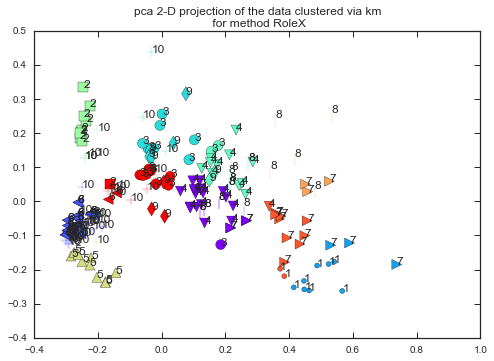

N is210
43
45
128
127
152
153
57
61
10
163
162
156
12
145
11
38
147
138
96
67
98
135
68
58
60
26
113
114
133
132
92
111
86
88
76
94
112
77
79
89
158
143
142
106
102
109
74
33
72
140
82
25
81
141
107
73
101
103
40
157
129
52
50
120
168
131
130
167
118
119
19
116
1
34
66
21
64
23
17
3
178
15
191
165
166
2
125
121
18
190
24
27
124
172
35
150
151
62
161
160
159
36
176
32
29
31
71
117
41
149
122
209
53
20
189
174
201
54
85
115
6
196
48
46
4
177
108
39
182
187
59
126
123
139
207
99
202
0
47
28
137
203
56
42
30
171
44
146
65
87
181
155
179
197
9
69
205
51
8
5
206
188
154
16
84
37
194
78
186
136
97
13
104
200
83
105
173
134
22
204
63
199
95
14
148
91
164
192
144
175
193
80
7
93
55
110
183
180
198
195
169
75
170
185
90
184
49
70
208
100
[[ 0.          5.53881407  5.72020664 ...,  4.78061869  4.47263171
   4.68392585]
 [ 5.53881407  0.          0.90783016 ...,  4.49621539  3.62286416
   5.06752974]
 [ 5.72020664  0.90783016  0.         ...,  4.66130788  4.00948549
   5.37008707]
 ..., 
 [ 4.7806

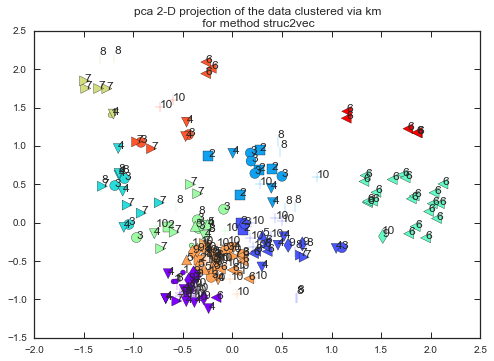

[[ 0.          0.18329043  0.15118725 ...,  0.20234046  0.1989074
   0.20429269]
 [ 0.18329043  0.          0.04258602 ...,  0.05575847  0.10580247
   0.05930183]
 [ 0.15118725  0.04258602  0.         ...,  0.06855343  0.10622455
   0.07746608]
 ..., 
 [ 0.20234046  0.05575847  0.06855343 ...,  0.          0.1052299
   0.05823541]
 [ 0.1989074   0.10580247  0.10622455 ...,  0.1052299   0.          0.12517551]
 [ 0.20429269  0.05930183  0.07746608 ...,  0.05823541  0.12517551  0.        ]]


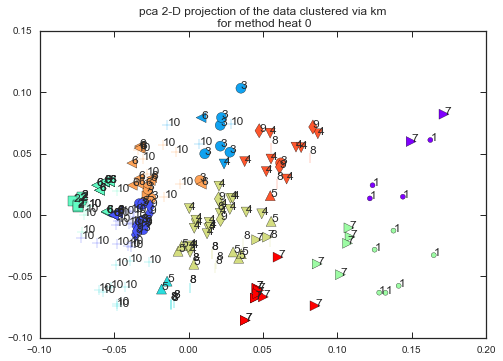

[[ 0.          0.13936977  0.12188547 ...,  0.17545256  0.20054517
   0.1813209 ]
 [ 0.13936977  0.          0.05870169 ...,  0.08300847  0.1681728
   0.10970611]
 [ 0.12188547  0.05870169  0.         ...,  0.094171    0.1731678
   0.12629469]
 ..., 
 [ 0.17545256  0.08300847  0.094171   ...,  0.          0.18539683
   0.08086822]
 [ 0.20054517  0.1681728   0.1731678  ...,  0.18539683  0.          0.22925434]
 [ 0.1813209   0.10970611  0.12629469 ...,  0.08086822  0.22925434  0.        ]]


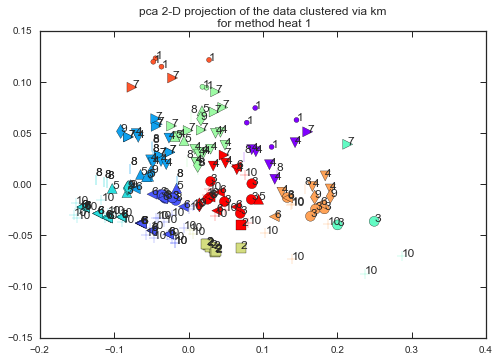

[[ 0.          0.16139247  0.13827871 ...,  0.18837481  0.22431143
   0.20875061]
 [ 0.16139247  0.          0.07072748 ...,  0.15488597  0.17270316
   0.13616097]
 [ 0.13827871  0.07072748  0.         ...,  0.15491824  0.17448082
   0.16361753]
 ..., 
 [ 0.18837481  0.15488597  0.15491824 ...,  0.          0.20191664
   0.12532639]
 [ 0.22431143  0.17270316  0.17448082 ...,  0.20191664  0.          0.24083694]
 [ 0.20875061  0.13616097  0.16361753 ...,  0.12532639  0.24083694  0.        ]]


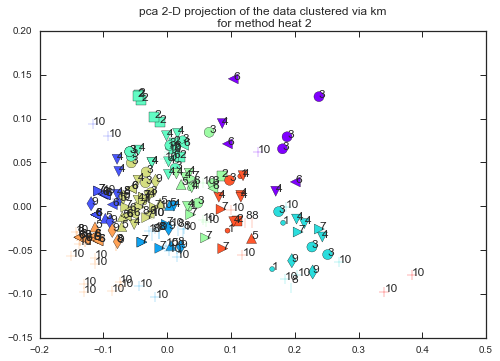

[[ 0.          0.15896766  0.14108842 ...,  0.2114016   0.21012841
   0.18403359]
 [ 0.15896766  0.          0.06560811 ...,  0.25962488  0.16871158
   0.16585844]
 [ 0.14108842  0.06560811  0.         ...,  0.24900739  0.1657204
   0.17494659]
 ..., 
 [ 0.2114016   0.25962488  0.24900739 ...,  0.          0.27271045
   0.16373614]
 [ 0.21012841  0.16871158  0.1657204  ...,  0.27271045  0.          0.22957334]
 [ 0.18403359  0.16585844  0.17494659 ...,  0.16373614  0.22957334  0.        ]]


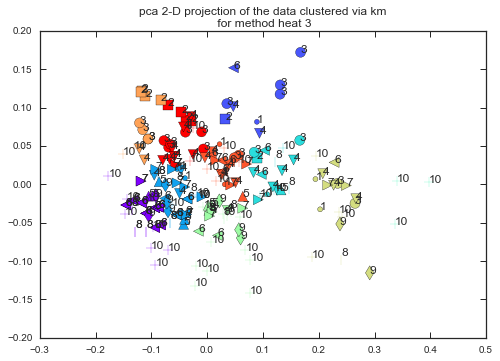

[[ 0.          0.14605774  0.13605497 ...,  0.22731999  0.18207647
   0.17312485]
 [ 0.14605774  0.          0.05010712 ...,  0.29349991  0.15819445
   0.18880571]
 [ 0.13605497  0.05010712  0.         ...,  0.27820729  0.14676342
   0.18904125]
 ..., 
 [ 0.22731999  0.29349991  0.27820729 ...,  0.          0.30663661
   0.15910119]
 [ 0.18207647  0.15819445  0.14676342 ...,  0.30663661  0.          0.23943582]
 [ 0.17312485  0.18880571  0.18904125 ...,  0.15910119  0.23943582  0.        ]]


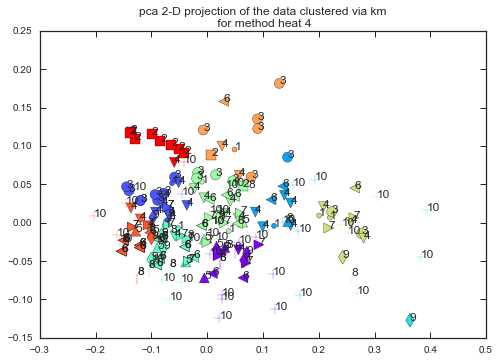

[[ 0.          0.18255827  0.15848954 ...,  0.24359832  0.17308258
   0.19689584]
 [ 0.18255827  0.          0.08733295 ...,  0.32421582  0.16047252
   0.21728312]
 [ 0.15848954  0.08733295  0.         ...,  0.30134113  0.15192722
   0.21561466]
 ..., 
 [ 0.24359832  0.32421582  0.30134113 ...,  0.          0.31796589
   0.1587546 ]
 [ 0.17308258  0.16047252  0.15192722 ...,  0.31796589  0.          0.2541722 ]
 [ 0.19689584  0.21728312  0.21561466 ...,  0.1587546   0.2541722   0.        ]]


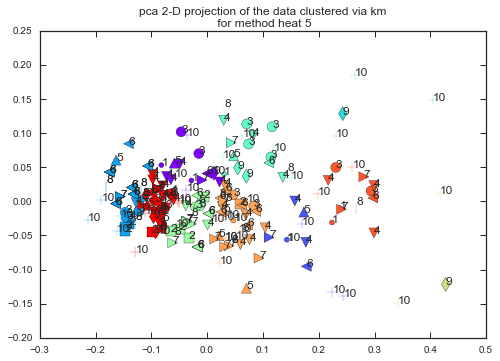

[[ 0.          0.16161592  0.13013409 ...,  0.25227049  0.17195521
   0.21138103]
 [ 0.16161592  0.          0.07537413 ...,  0.33441708  0.1214102
   0.24917715]
 [ 0.13013409  0.07537413  0.         ...,  0.32282731  0.13147822
   0.24727672]
 ..., 
 [ 0.25227049  0.33441708  0.32282731 ...,  0.          0.32070655
   0.1629897 ]
 [ 0.17195521  0.1214102   0.13147822 ...,  0.32070655  0.          0.26684423]
 [ 0.21138103  0.24917715  0.24727672 ...,  0.1629897   0.26684423  0.        ]]


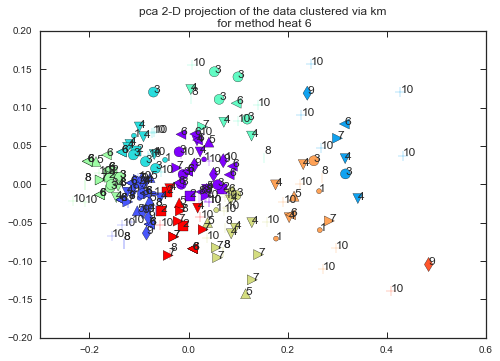

[[ 0.          0.15751876  0.12984192 ...,  0.27612988  0.15818415
   0.23069696]
 [ 0.15751876  0.          0.0723865  ...,  0.36460966  0.12751637
   0.27869119]
 [ 0.12984192  0.0723865   0.         ...,  0.35835737  0.11763245
   0.29201976]
 ..., 
 [ 0.27612988  0.36460966  0.35835737 ...,  0.          0.3319656
   0.18657014]
 [ 0.15818415  0.12751637  0.11763245 ...,  0.3319656   0.          0.27898163]
 [ 0.23069696  0.27869119  0.29201976 ...,  0.18657014  0.27898163  0.        ]]


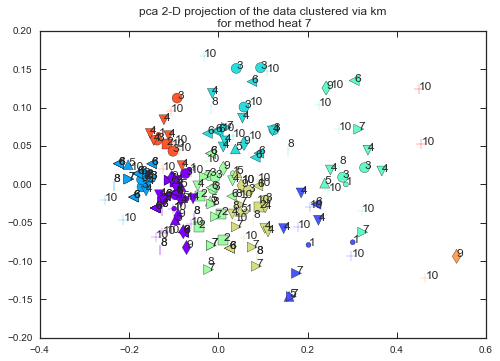

[[ 0.          0.16249578  0.14327805 ...,  0.30078066  0.14157785
   0.22687031]
 [ 0.16249578  0.          0.0893641  ...,  0.39376062  0.13552233
   0.2838325 ]
 [ 0.14327805  0.0893641   0.         ...,  0.39714228  0.11031105
   0.30523155]
 ..., 
 [ 0.30078066  0.39376062  0.39714228 ...,  0.          0.35967233
   0.18942959]
 [ 0.14157785  0.13552233  0.11031105 ...,  0.35967233  0.          0.28150226]
 [ 0.22687031  0.2838325   0.30523155 ...,  0.18942959  0.28150226  0.        ]]


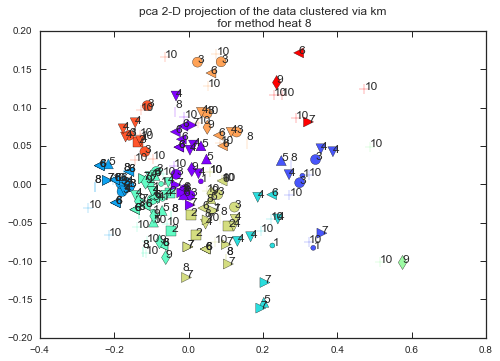

[[ 0.          0.16945253  0.15249712 ...,  0.33595003  0.14880932
   0.21944888]
 [ 0.16945253  0.          0.10303992 ...,  0.42606762  0.14478304
   0.28770256]
 [ 0.15249712  0.10303992  0.         ...,  0.43743798  0.10607817
   0.29824234]
 ..., 
 [ 0.33595003  0.42606762  0.43743798 ...,  0.          0.41131617
   0.2262679 ]
 [ 0.14880932  0.14478304  0.10607817 ...,  0.41131617  0.          0.28094745]
 [ 0.21944888  0.28770256  0.29824234 ...,  0.2262679   0.28094745  0.        ]]


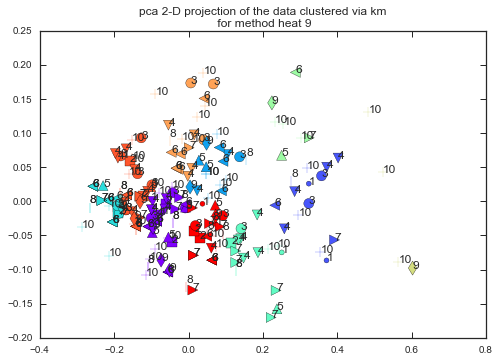

[[ 0.          0.17782299  0.15889505 ...,  0.37017178  0.15665217
   0.22729979]
 [ 0.17782299  0.          0.11046557 ...,  0.45684108  0.15537945
   0.30678954]
 [ 0.15889505  0.11046557  0.         ...,  0.4674311   0.11427167
   0.30839528]
 ..., 
 [ 0.37017178  0.45684108  0.4674311  ...,  0.          0.4530596
   0.28151448]
 [ 0.15665217  0.15537945  0.11427167 ...,  0.4530596   0.          0.28682516]
 [ 0.22729979  0.30678954  0.30839528 ...,  0.28151448  0.28682516  0.        ]]


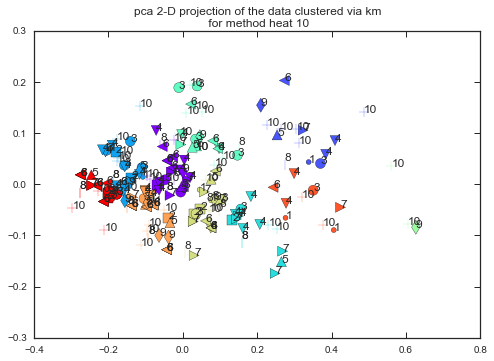

[[ 0.          0.1869984   0.16396158 ...,  0.39506326  0.15738     0.23587581]
 [ 0.1869984   0.          0.1141263  ...,  0.48149749  0.16150665
   0.32576944]
 [ 0.16396158  0.1141263   0.         ...,  0.48615032  0.11243128
   0.32564253]
 ..., 
 [ 0.39506326  0.48149749  0.48615032 ...,  0.          0.47402632
   0.30807374]
 [ 0.15738     0.16150665  0.11243128 ...,  0.47402632  0.          0.30409448]
 [ 0.23587581  0.32576944  0.32564253 ...,  0.30807374  0.30409448  0.        ]]


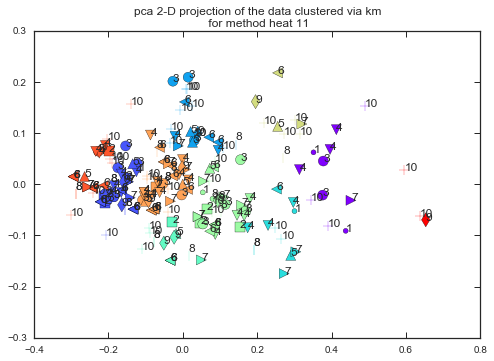

[[ 0.          0.19647079  0.16796377 ...,  0.41718257  0.1656347
   0.2401952 ]
 [ 0.19647079  0.          0.11574874 ...,  0.50629402  0.17026606
   0.33632714]
 [ 0.16796377  0.11574874  0.         ...,  0.50544415  0.11071681
   0.33551081]
 ..., 
 [ 0.41718257  0.50629402  0.50544415 ...,  0.          0.49984033
   0.31548036]
 [ 0.1656347   0.17026606  0.11071681 ...,  0.49984033  0.          0.32594981]
 [ 0.2401952   0.33632714  0.33551081 ...,  0.31548036  0.32594981  0.        ]]


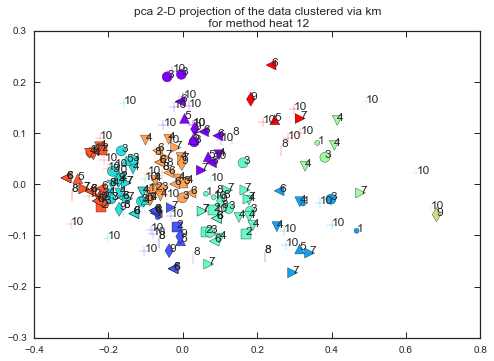

[[ 0.          0.20581502  0.17101344 ...,  0.44527819  0.17510473
   0.24305479]
 [ 0.20581502  0.          0.1164305  ...,  0.53573     0.17790801
   0.34059098]
 [ 0.17101344  0.1164305   0.         ...,  0.53114466  0.11781139
   0.33727505]
 ..., 
 [ 0.44527819  0.53573     0.53114466 ...,  0.          0.53961388
   0.32731766]
 [ 0.17510473  0.17790801  0.11781139 ...,  0.53961388  0.          0.33925941]
 [ 0.24305479  0.34059098  0.33727505 ...,  0.32731766  0.33925941  0.        ]]


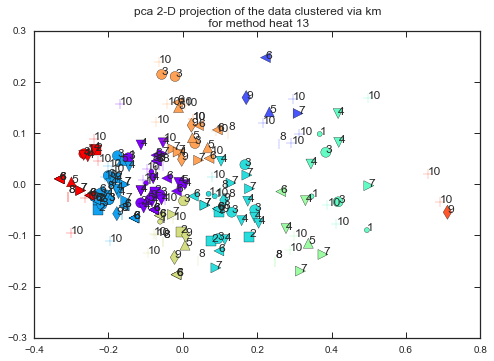

[[ 0.          0.21459931  0.17345844 ...,  0.48125409  0.17642044
   0.2464625 ]
 [ 0.21459931  0.          0.11698759 ...,  0.56815354  0.17610205
   0.34265127]
 [ 0.17345844  0.11698759  0.         ...,  0.56059003  0.12530461
   0.33522548]
 ..., 
 [ 0.48125409  0.56815354  0.56059003 ...,  0.          0.58146089
   0.35288121]
 [ 0.17642044  0.17610205  0.12530461 ...,  0.58146089  0.          0.33944816]
 [ 0.2464625   0.34265127  0.33522548 ...,  0.35288121  0.33944816  0.        ]]


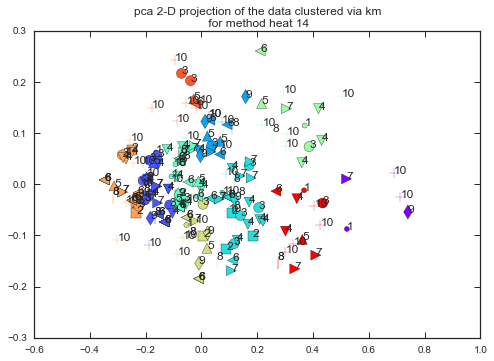

[[ 0.          0.22241325  0.17582596 ...,  0.5216444   0.17461965
   0.25058274]
 [ 0.22241325  0.          0.11799633 ...,  0.5998815   0.16468238
   0.34496008]
 [ 0.17582596  0.11799633  0.         ...,  0.58926088  0.1287857
   0.33280965]
 ..., 
 [ 0.5216444   0.5998815   0.58926088 ...,  0.          0.6164759
   0.38731981]
 [ 0.17461965  0.16468238  0.1287857  ...,  0.6164759   0.          0.33235198]
 [ 0.25058274  0.34496008  0.33280965 ...,  0.38731981  0.33235198  0.        ]]


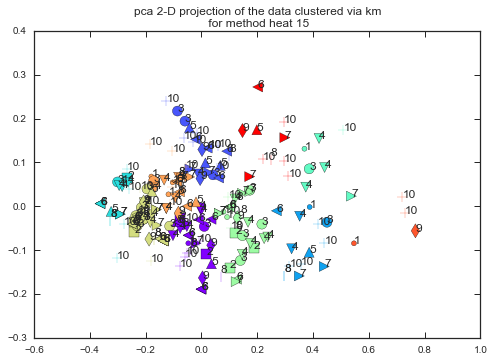

[[ 0.          0.22893206  0.1786286  ...,  0.5622702   0.17913828
   0.25502396]
 [ 0.22893206  0.          0.11974449 ...,  0.6285621   0.15020716
   0.34821547]
 [ 0.1786286   0.11974449  0.         ...,  0.61466542  0.13237841
   0.33153028]
 ..., 
 [ 0.5622702   0.6285621   0.61466542 ...,  0.          0.64484615
   0.42320953]
 [ 0.17913828  0.15020716  0.13237841 ...,  0.64484615  0.          0.32658514]
 [ 0.25502396  0.34821547  0.33153028 ...,  0.42320953  0.32658514  0.        ]]


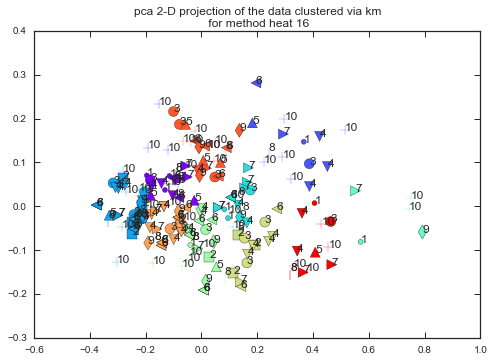

[[ 0.          0.23395551  0.18218825 ...,  0.6005787   0.19112639
   0.25956441]
 [ 0.23395551  0.          0.12222522 ...,  0.65366192  0.13966774
   0.35218555]
 [ 0.18218825  0.12222522  0.         ...,  0.63646419  0.14047729
   0.33158086]
 ..., 
 [ 0.6005787   0.65366192  0.63646419 ...,  0.          0.66996952
   0.45631687]
 [ 0.19112639  0.13966774  0.14047729 ...,  0.66996952  0.          0.32657124]
 [ 0.25956441  0.35218555  0.33158086 ...,  0.45631687  0.32657124  0.        ]]


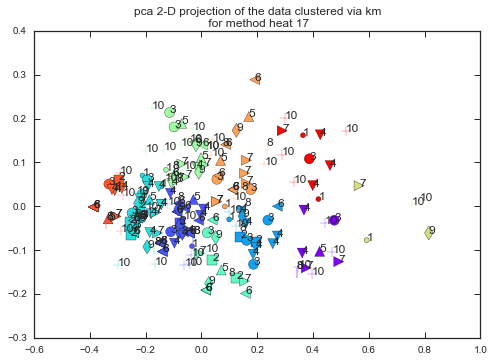

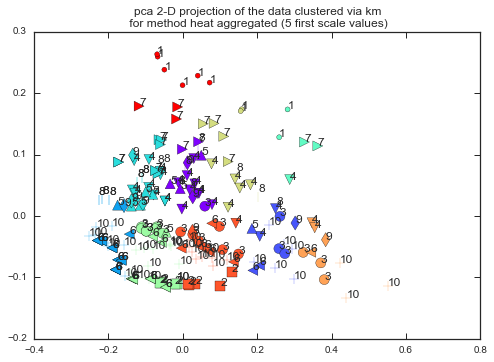

smax= 18  and smin= 5


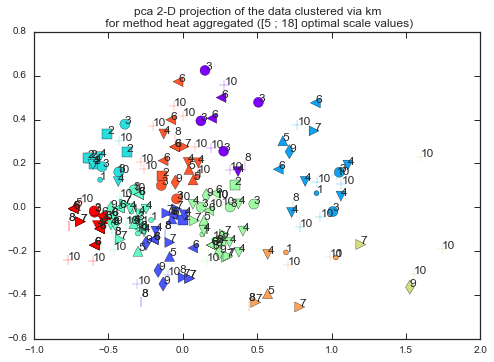

smax= 19  and smin= 6


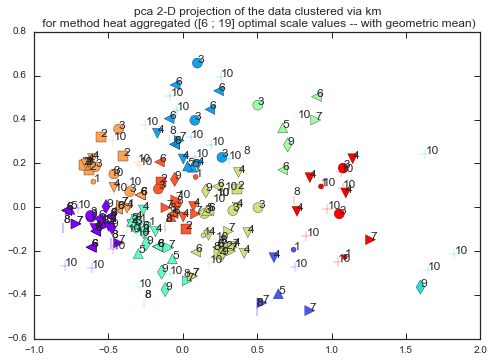

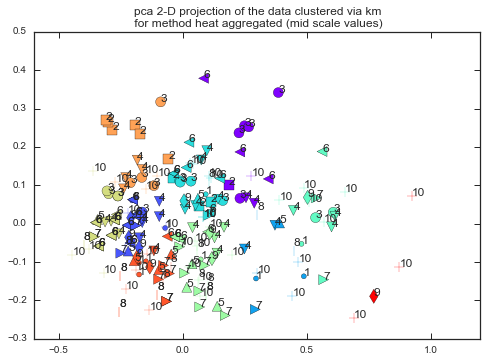

In [6]:
### 1.  Select the range of scales and compute the associated heat wavelets
taus=range(1,20,1)
heat_print=heat_diffusion(G,taus,diff_type="immediate",type_graph="nx")
perf={}
N=nx.number_of_nodes(G)
nb_clust=len(np.unique(index_roles))
### 2. Conduct the comparative analysis described in the introduction passing these wavelets as input
D, chi, Perf,D_classes=clustering_comparative_analysis(G, index_roles, heat_print,nb_clust,dirpath='../../structural_equivalents',graph_nodes_name=name_graph+'_nodes.txt',graph_edges_name=name_graph+'_edges.txt',agg_max=5,struc2vec_input=name_graph+'_edges.txt',struc2vec_output=name_graph+'_struc2vec.txt')

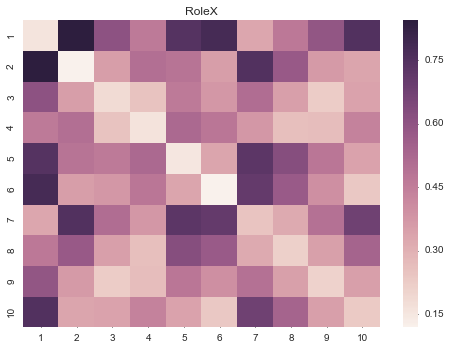

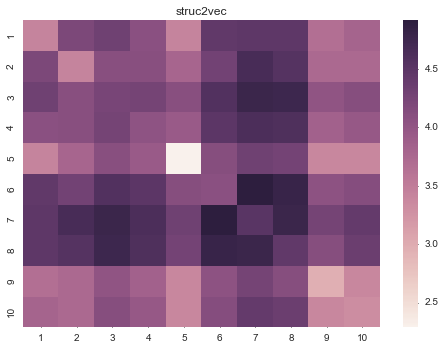

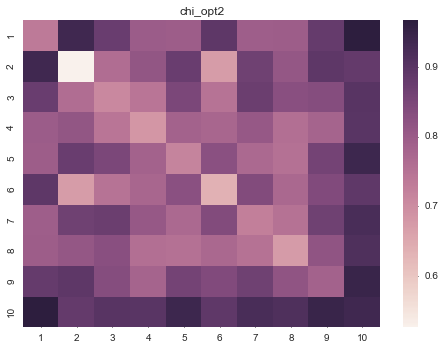

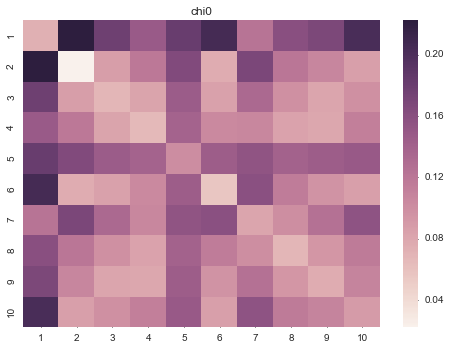

In [7]:
plt.figure()
sb.heatmap(D_classes['RoleX'])
plt.title('RoleX')
plt.figure()
sb.heatmap(D_classes['struc2vec'])
plt.title('struc2vec')
plt.figure()
sb.heatmap(D_classes['chi_opt2'])
plt.title('chi_opt2')
plt.figure()
sb.heatmap(D_classes['chi0'])
plt.title('chi0')

In [8]:
 Perf

homogeneity  completeness     score   purity1   purity2  \
chi_agg1_5       0.348950      0.351564  0.000000  0.819048  1.519048   
chi10            0.101767      0.100990  0.458730  0.580952  1.019048   
chi11            0.099349      0.101929  0.430159  0.552381  1.009524   
chi12            0.104014      0.105503  0.420635  0.561905  0.980952   
chi13            0.109542      0.111422  0.415873  0.542857  0.971429   
chi14            0.100560      0.100086  0.415873  0.528571  0.980952   
chi15            0.096818      0.098171  0.406349  0.547619  0.971429   
chi16            0.111848      0.110686  0.412698  0.547619  0.976190   
chi17            0.116812      0.116951  0.417460  0.547619  0.971429   
struc2vec        0.247591      0.250950  0.382540  0.476190  0.814286   
chi8             0.126551      0.131856  0.492063  0.585714  1.104762   
chi9             0.108719      0.109683  0.468254  0.566667  1.080952   
chi2             0.219081      0.218909  0.682540  0.790476  1.428571   
chi3             0.223165      0.225115  0.641270  0.752381  1.380952   
chi0             0.504938      0.509685  0.773016  0.780952  1.585714   
chi1             0.361064      0.365161  0.690476  0.809524  1.495238   
chi6             0.123471      0.124999  0.552381  0.685714  1.223810   
chi7             0.111954      0.117314  0.526984  0.633333  1.166667   
chi4             0.215875      0.217971  0.568254  0.695238  1.228571   
chi5             0.117812      0.123317  0.606349  0.676190  1.333333   
chi_opt2         0.119492      0.120825  0.000000  0.623810  1.100000   
chi_opt1_18      0.131854      0.131335  0.000000  0.661905  1.157143   
chi_agg1_mid     0.182464      0.180871  0.000000  0.785714  1.447619   
RoleX            0.607525      0.626089  0.820635  0.871429  1.700000   

               purity3   purity4   purity5   purity6   purity7   purity8  \
chi_agg1_5    2.166667  2.814286  3.304762  3.752381  4.161905  4.633333   
chi10         1.376190  1.680952  1.995238  2.319048  2.585714  2.847619   
chi11         1.290476  1.609524  1.952381  2.223810  2.471429  2.709524   
chi12         1.261905  1.580952  1.866667  2.109524  2.361905  2.571429   
chi13         1.247619  1.580952  1.857143  2.076190  2.309524  2.533333   
chi14         1.247619  1.533333  1.776190  2.004762  2.233333  2.480952   
chi15         1.219048  1.523810  1.809524  2.028571  2.233333  2.461905   
chi16         1.238095  1.538095  1.771429  1.961905  2.133333  2.323810   
chi17         1.252381  1.509524  1.728571  1.904762  2.057143  2.247619   
struc2vec     1.147619  1.438095  1.695238  1.904762  2.147619  2.361905   
chi8          1.476190  1.880952  2.228571  2.504762  2.852381  3.152381   
chi9          1.404762  1.747619  2.095238  2.409524  2.671429  2.938095   
chi2          2.047619  2.557143  3.014286  3.385714  3.747619  4.133333   
chi3          1.923810  2.476190  2.919048  3.309524  3.680952  3.990476   
chi0          2.319048  2.990476  3.633333  4.247619  4.776190  5.261905   
chi1          2.071429  2.585714  3.123810  3.633333  4.061905  4.419048   
chi6          1.657143  2.019048  2.361905  2.585714  2.857143  3.152381   
chi7          1.580952  1.928571  2.257143  2.523810  2.833333  3.114286   
chi4          1.704762  2.166667  2.585714  2.938095  3.271429  3.628571   
chi5          1.819048  2.257143  2.642857  2.914286  3.228571  3.476190   
chi_opt2      1.480952  1.780952  2.157143  2.461905  2.733333  2.938095   
chi_opt1_18   1.514286  1.852381  2.247619  2.557143  2.842857  3.057143   
chi_agg1_mid  1.947619  2.433333  2.880952  3.266667  3.633333  3.942857   
RoleX         2.461905  3.266667  4.042857  4.800000  5.466667  6.109524   

               purity9  purity10  purity11  purity12  purity13  purity14  \
chi_agg1_5    5.076190  5.490476  5.857143  6.147619  6.409524  6.695238   
chi10         3.042857  3.242857  3.476190  3.719048  3.928571  4.104762   
chi11         2.952381  3.171429  3.400000  3.600000  3.771

## Comparing the clustering results

As detailed in the introduction, to quantify the performance of the method and the relevance of the topological representations that it yields, we assess compare the clustering obtained by using these representation as input.

starting summary
start= 0
start= 7
start= 14
start= 21
start= 28
start= 35
start= 42
start= 49
start= 56
start= 63
start= 70
start= 75
start= 80
start= 85
start= 90
start= 95
start= 100
start= 105
start= 110
start= 115
start= 120
start= 125
start= 130
start= 135
start= 140
start= 145
start= 150
start= 155
start= 160
start= 165
(0, 64)
[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 

2017-10-04 17:18:04,157:[INFO](pygsp.filters.filter.__init__): Heat : has to compute lmax
2017-10-04 17:18:04,170:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 17:18:04,218:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 17:18:04,269:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 17:18:04,315:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 17:18:04,350:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 17:18:04,400:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 17:18:04,457:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 17:18:04,490:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 17:18:04,555:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 17:18:04,680:[INFO](pygsp.filters.filter.analysis): The analysis method

Creating Vertex Features matrix
V is a 210 by 180 matrix.
Node-role matrix is of dimensions 210 by 10
[[  2455.              0.0787194      14.         ...,      0.01025507
       0.01025507     14.        ]
 [     0.              0.07302586      4.         ...,      0.00327865
       0.00327865      4.        ]
 [     1.              0.07305138      6.         ...,      0.00465567
       0.00465567      6.        ]
 ..., 
 [ 10136.              0.07630522      4.         ...,      0.00413424
       0.00413424      4.        ]
 [  1933.26666667      0.06129032      4.         ...,      0.00422971
       0.00422971      4.        ]
 [ 10048.              0.07224335      6.         ...,      0.00622415
       0.00622415      6.        ]]
[[ 0.          0.01562216  0.00747721  0.01502721  0.00179302  0.          0.
   0.0074805 ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.06886906  0.          0.06906627  0.06247322  0.   

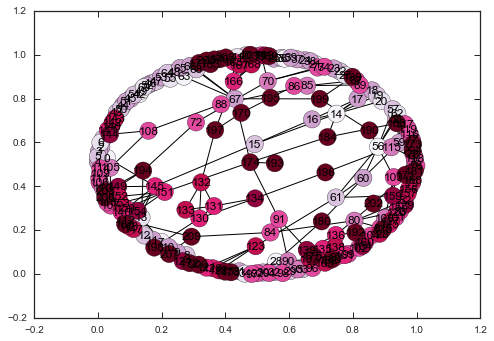

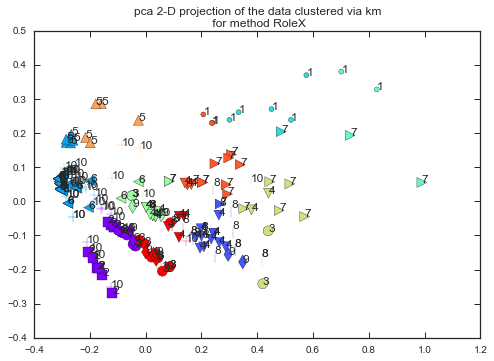

N is210
168
167
19
17
18
150
46
44
66
4
2
33
68
157
158
1
5
57
43
47
64
169
148
147
71
153
128
127
74
73
121
120
58
48
41
93
152
10
92
65
94
51
50
45
180
163
81
3
162
114
113
82
111
109
107
106
83
9
116
117
38
141
140
102
119
8
104
131
89
87
130
101
37
142
143
36
34
42
99
35
98
96
77
39
79
78
154
24
40
129
138
84
112
135
22
125
126
54
23
62
52
100
151
103
69
164
139
122
170
166
193
202
11
13
59
20
56
110
61
80
21
160
12
16
203
72
184
161
6
159
123
188
207
172
190
26
15
185
181
118
189
179
14
70
30
7
175
149
176
197
28
63
134
29
196
32
31
97
133
132
91
165
27
88
25
60
55
156
195
53
177
146
67
200
49
137
144
90
124
182
205
199
186
155
86
76
206
191
201
198
85
194
204
192
187
0
115
209
173
183
208
108
178
95
105
145
75
136
171
174
[[ 0.          3.51798768  3.54648874 ...,  4.20983357  2.66254726
   2.669916  ]
 [ 3.51798768  0.          0.62608838 ...,  4.63796335  3.38617321
   3.46643787]
 [ 3.54648874  0.62608838  0.         ...,  4.7237681   3.54010278
   3.60216023]
 ..., 
 [ 4.2098

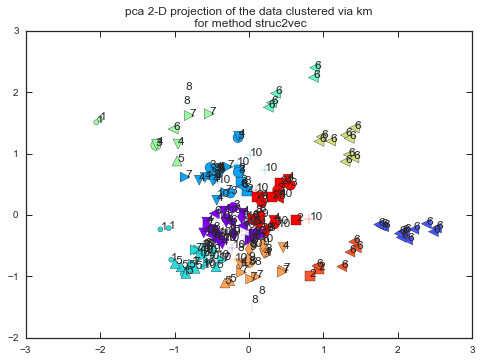

[[ 0.          0.19737313  0.16944321 ...,  0.21301384  0.20804458
   0.21073476]
 [ 0.19737313  0.          0.04585154 ...,  0.07406753  0.10620533
   0.10134663]
 [ 0.16944321  0.04585154  0.         ...,  0.07142917  0.09965347
   0.08791862]
 ..., 
 [ 0.21301384  0.07406753  0.07142917 ...,  0.          0.11757451
   0.05500796]
 [ 0.20804458  0.10620533  0.09965347 ...,  0.11757451  0.          0.13615413]
 [ 0.21073476  0.10134663  0.08791862 ...,  0.05500796  0.13615413  0.        ]]


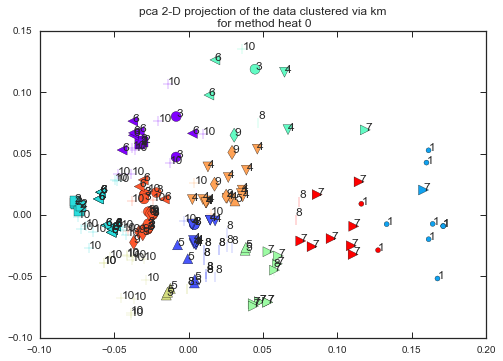

[[ 0.          0.17934404  0.1692363  ...,  0.22683543  0.25357925
   0.21843795]
 [ 0.17934404  0.          0.06067986 ...,  0.09102967  0.16934467
   0.10976413]
 [ 0.1692363   0.06067986  0.         ...,  0.08416149  0.16423668
   0.12273164]
 ..., 
 [ 0.22683543  0.09102967  0.08416149 ...,  0.          0.17269889
   0.09937999]
 [ 0.25357925  0.16934467  0.16423668 ...,  0.17269889  0.          0.21584485]
 [ 0.21843795  0.10976413  0.12273164 ...,  0.09937999  0.21584485  0.        ]]


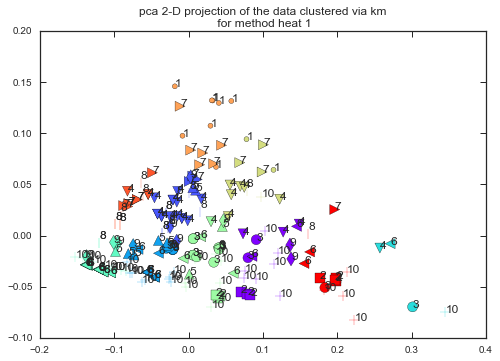

[[ 0.          0.24269677  0.22171489 ...,  0.26667091  0.28160209
   0.23711441]
 [ 0.24269677  0.          0.08041457 ...,  0.11545841  0.16196058
   0.1724631 ]
 [ 0.22171489  0.08041457  0.         ...,  0.10325832  0.16047386
   0.16955463]
 ..., 
 [ 0.26667091  0.11545841  0.10325832 ...,  0.          0.15900819
   0.12402849]
 [ 0.28160209  0.16196058  0.16047386 ...,  0.15900819  0.          0.22217638]
 [ 0.23711441  0.1724631   0.16955463 ...,  0.12402849  0.22217638  0.        ]]


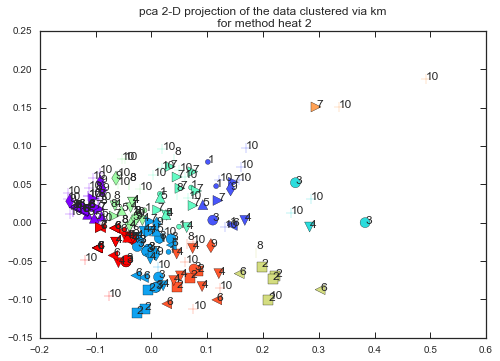

[[ 0.          0.25437597  0.23282752 ...,  0.20647668  0.27490722
   0.15630053]
 [ 0.25437597  0.          0.07879257 ...,  0.16519874  0.14021501
   0.30442811]
 [ 0.23282752  0.07879257  0.         ...,  0.14513003  0.15472466
   0.28524538]
 ..., 
 [ 0.20647668  0.16519874  0.14513003 ...,  0.          0.1810165
   0.19139813]
 [ 0.27490722  0.14021501  0.15472466 ...,  0.1810165   0.          0.31120655]
 [ 0.15630053  0.30442811  0.28524538 ...,  0.19139813  0.31120655  0.        ]]


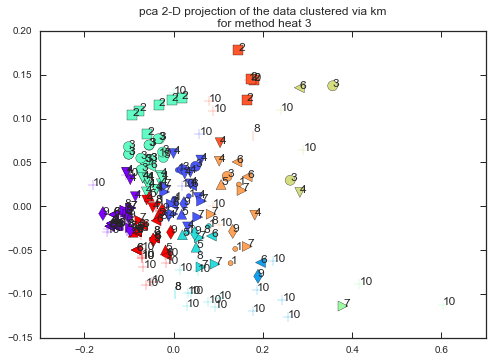

[[ 0.          0.23994861  0.22595498 ...,  0.19155118  0.25983674
   0.19047596]
 [ 0.23994861  0.          0.05166749 ...,  0.2049699   0.15253285
   0.36514705]
 [ 0.22595498  0.05166749  0.         ...,  0.19338315  0.14081638
   0.35379524]
 ..., 
 [ 0.19155118  0.2049699   0.19338315 ...,  0.          0.19594205
   0.22739542]
 [ 0.25983674  0.15253285  0.14081638 ...,  0.19594205  0.          0.35276525]
 [ 0.19047596  0.36514705  0.35379524 ...,  0.22739542  0.35276525  0.        ]]


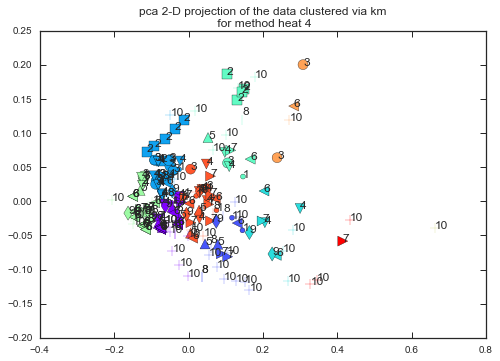

[[ 0.          0.25902424  0.22603689 ...,  0.20270669  0.24637035
   0.20806444]
 [ 0.25902424  0.          0.07751673 ...,  0.24206757  0.16339401
   0.38050087]
 [ 0.22603689  0.07751673  0.         ...,  0.23243931  0.12191736
   0.36945035]
 ..., 
 [ 0.20270669  0.24206757  0.23243931 ...,  0.          0.23275772
   0.26671915]
 [ 0.24637035  0.16339401  0.12191736 ...,  0.23275772  0.          0.36970936]
 [ 0.20806444  0.38050087  0.36945035 ...,  0.26671915  0.36970936  0.        ]]


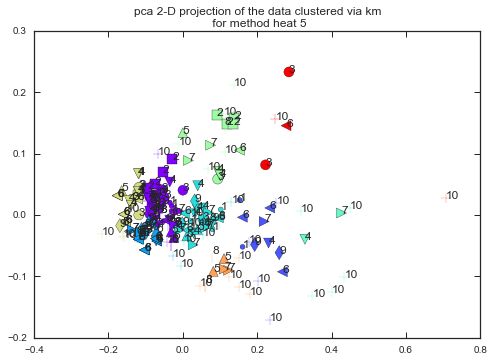

[[ 0.          0.23392667  0.19855418 ...,  0.23567173  0.2129685
   0.22859406]
 [ 0.23392667  0.          0.07359797 ...,  0.2802324   0.15583473
   0.38122122]
 [ 0.19855418  0.07359797  0.         ...,  0.28536026  0.12846023
   0.37387211]
 ..., 
 [ 0.23567173  0.2802324   0.28536026 ...,  0.          0.26688944
   0.30444595]
 [ 0.2129685   0.15583473  0.12846023 ...,  0.26688944  0.          0.3793511 ]
 [ 0.22859406  0.38122122  0.37387211 ...,  0.30444595  0.3793511   0.        ]]


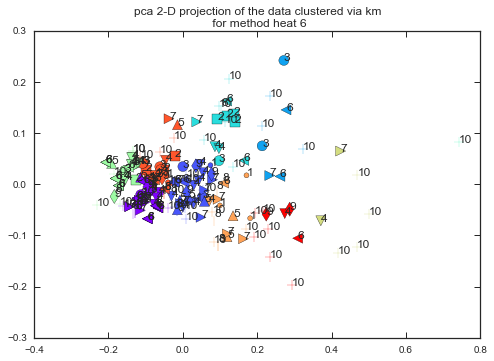

[[ 0.          0.21747116  0.18466406 ...,  0.2508501   0.1896537
   0.21504819]
 [ 0.21747116  0.          0.06634599 ...,  0.30684402  0.14531563
   0.36877848]
 [ 0.18466406  0.06634599  0.         ...,  0.3034376   0.14126936
   0.35283629]
 ..., 
 [ 0.2508501   0.30684402  0.3034376  ...,  0.          0.27546379
   0.2885779 ]
 [ 0.1896537   0.14531563  0.14126936 ...,  0.27546379  0.          0.35273347]
 [ 0.21504819  0.36877848  0.35283629 ...,  0.2885779   0.35273347  0.        ]]


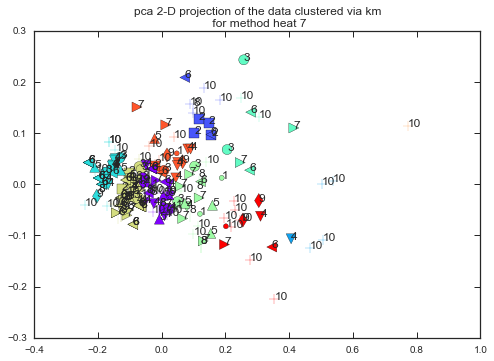

[[ 0.          0.21330862  0.18131222 ...,  0.28421283  0.18664068
   0.21111742]
 [ 0.21330862  0.          0.08064713 ...,  0.34621568  0.14985253
   0.35076328]
 [ 0.18131222  0.08064713  0.         ...,  0.32820523  0.1602903
   0.33958681]
 ..., 
 [ 0.28421283  0.34621568  0.32820523 ...,  0.          0.28442091
   0.283169  ]
 [ 0.18664068  0.14985253  0.1602903  ...,  0.28442091  0.          0.32394562]
 [ 0.21111742  0.35076328  0.33958681 ...,  0.283169    0.32394562  0.        ]]


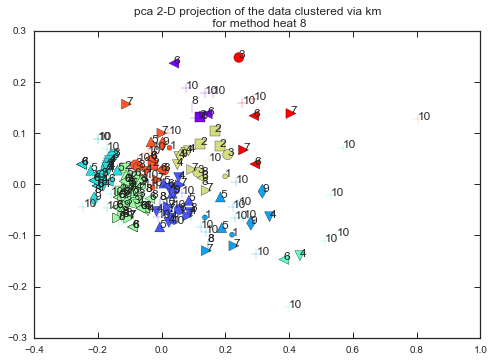

[[ 0.          0.20835741  0.17996859 ...,  0.31920879  0.18858198
   0.22306017]
 [ 0.20835741  0.          0.09889419 ...,  0.37668863  0.16253247
   0.33060022]
 [ 0.17996859  0.09889419  0.         ...,  0.35493424  0.17804435
   0.33660575]
 ..., 
 [ 0.31920879  0.37668863  0.35493424 ...,  0.          0.285687
   0.28775539]
 [ 0.18858198  0.16253247  0.17804435 ...,  0.285687    0.          0.29674257]
 [ 0.22306017  0.33060022  0.33660575 ...,  0.28775539  0.29674257  0.        ]]


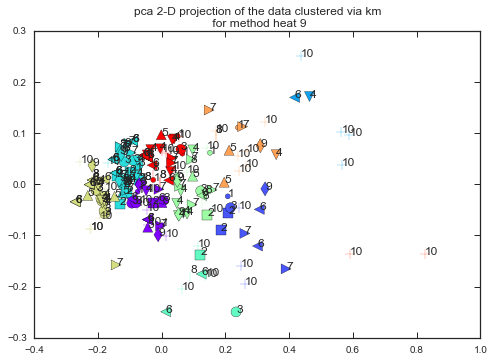

[[ 0.          0.20162695  0.17840818 ...,  0.3339114   0.18891401
   0.23094226]
 [ 0.20162695  0.          0.11301304 ...,  0.38960633  0.17478759
   0.31882027]
 [ 0.17840818  0.11301304  0.         ...,  0.37018505  0.19139521
   0.33588186]
 ..., 
 [ 0.3339114   0.38960633  0.37018505 ...,  0.          0.27706389
   0.28392253]
 [ 0.18891401  0.17478759  0.19139521 ...,  0.27706389  0.          0.28332164]
 [ 0.23094226  0.31882027  0.33588186 ...,  0.28392253  0.28332164  0.        ]]


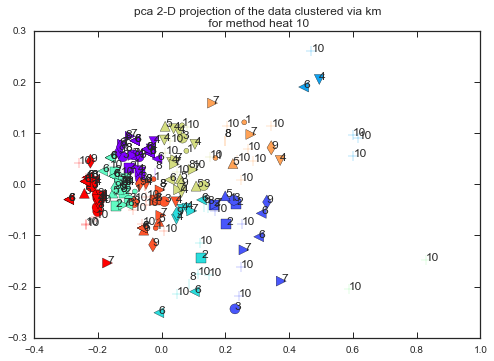

[[ 0.          0.19451097  0.17638922 ...,  0.33245275  0.18606909
   0.22992188]
 [ 0.19451097  0.          0.12261349 ...,  0.3930075   0.18555768
   0.31211648]
 [ 0.17638922  0.12261349  0.         ...,  0.37703904  0.19847838
   0.32942104]
 ..., 
 [ 0.33245275  0.3930075   0.37703904 ...,  0.          0.26748419
   0.2602495 ]
 [ 0.18606909  0.18555768  0.19847838 ...,  0.26748419  0.          0.27449076]
 [ 0.22992188  0.31211648  0.32942104 ...,  0.2602495   0.27449076  0.        ]]


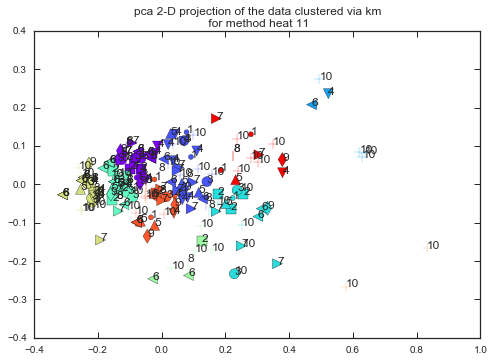

[[ 0.          0.18821696  0.17375896 ...,  0.32660565  0.18409564
   0.22927541]
 [ 0.18821696  0.          0.12876781 ...,  0.39553494  0.19755074
   0.30916276]
 [ 0.17375896  0.12876781  0.         ...,  0.38203701  0.20064153
   0.31997474]
 ..., 
 [ 0.32660565  0.39553494  0.38203701 ...,  0.          0.26098878
   0.22407308]
 [ 0.18409564  0.19755074  0.20064153 ...,  0.26098878  0.          0.26361754]
 [ 0.22927541  0.30916276  0.31997474 ...,  0.22407308  0.26361754  0.        ]]


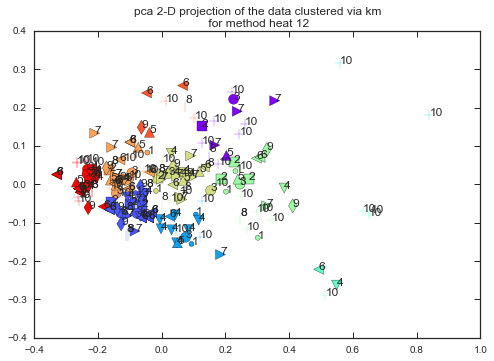

[[ 0.          0.18371968  0.17050603 ...,  0.3244626   0.18864378
   0.23367978]
 [ 0.18371968  0.          0.13244881 ...,  0.40126121  0.21311356
   0.31122132]
 [ 0.17050603  0.13244881  0.         ...,  0.3888117   0.20210096
   0.31351685]
 ..., 
 [ 0.3244626   0.40126121  0.3888117  ...,  0.          0.25738714
   0.18995565]
 [ 0.18864378  0.21311356  0.20210096 ...,  0.25738714  0.          0.25289562]
 [ 0.23367978  0.31122132  0.31351685 ...,  0.18995565  0.25289562  0.        ]]


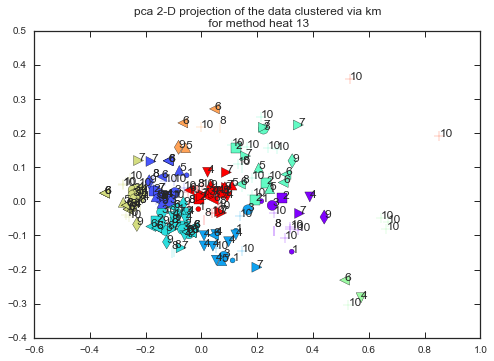

[[ 0.          0.181684    0.16699352 ...,  0.32781944  0.19837918
   0.24104132]
 [ 0.181684    0.          0.13437614 ...,  0.41030716  0.23116115
   0.3177138 ]
 [ 0.16699352  0.13437614  0.         ...,  0.39792368  0.20623845
   0.3126051 ]
 ..., 
 [ 0.32781944  0.41030716  0.39792368 ...,  0.          0.25681488
   0.16714758]
 [ 0.19837918  0.23116115  0.20623845 ...,  0.25681488  0.          0.24373666]
 [ 0.24104132  0.3177138   0.3126051  ...,  0.16714758  0.24373666  0.        ]]


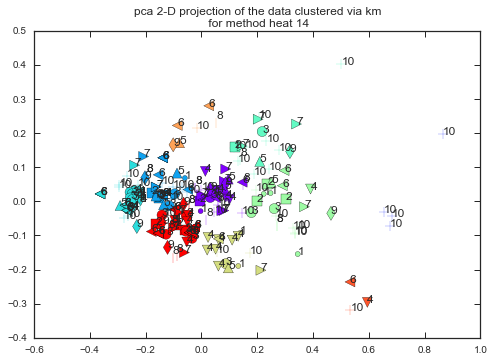

[[ 0.          0.18231929  0.16393083 ...,  0.33451131  0.20748836
   0.24844364]
 [ 0.18231929  0.          0.13510258 ...,  0.42099604  0.24884173
   0.32671511]
 [ 0.16393083  0.13510258  0.         ...,  0.40838406  0.21405441
   0.31662296]
 ..., 
 [ 0.33451131  0.42099604  0.40838406 ...,  0.          0.26044803
   0.15592648]
 [ 0.20748836  0.24884173  0.21405441 ...,  0.26044803  0.          0.23605882]
 [ 0.24844364  0.32671511  0.31662296 ...,  0.15592648  0.23605882  0.        ]]


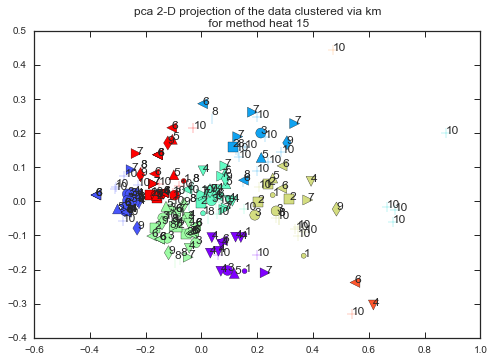

[[ 0.          0.18535533  0.16216919 ...,  0.34178006  0.21252528
   0.25469937]
 [ 0.18535533  0.          0.13507253 ...,  0.43156175  0.26399922
   0.33653951]
 [ 0.16216919  0.13507253  0.         ...,  0.41895153  0.22481873
   0.32401086]
 ..., 
 [ 0.34178006  0.43156175  0.41895153 ...,  0.          0.26853088
   0.15159357]
 [ 0.21252528  0.26399922  0.22481873 ...,  0.26853088  0.          0.23071071]
 [ 0.25469937  0.33653951  0.32401086 ...,  0.15159357  0.23071071  0.        ]]


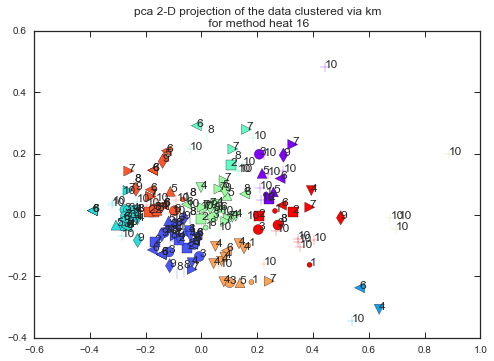

[[ 0.          0.1901762   0.16243893 ...,  0.34803787  0.21388858
   0.25984617]
 [ 0.1901762   0.          0.13463388 ...,  0.44088754  0.27579238
   0.34622231]
 [ 0.16243893  0.13463388  0.         ...,  0.42875465  0.23717591
   0.33346675]
 ..., 
 [ 0.34803787  0.44088754  0.42875465 ...,  0.          0.27920993
   0.15006229]
 [ 0.21388858  0.27579238  0.23717591 ...,  0.27920993  0.          0.22883836]
 [ 0.25984617  0.34622231  0.33346675 ...,  0.15006229  0.22883836  0.        ]]


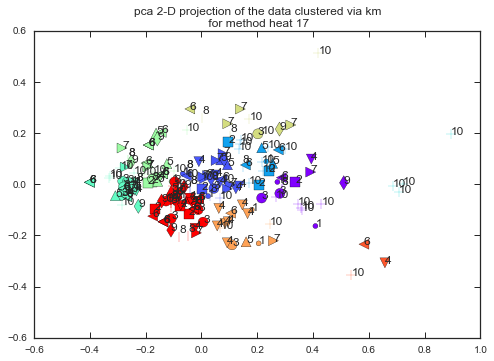

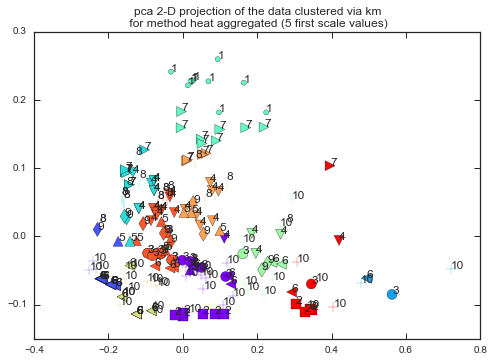

smax= 18  and smin= 5


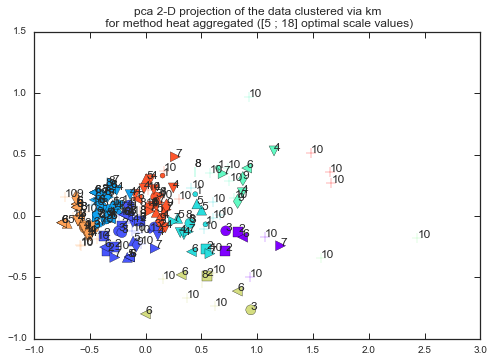

smax= 19  and smin= 4


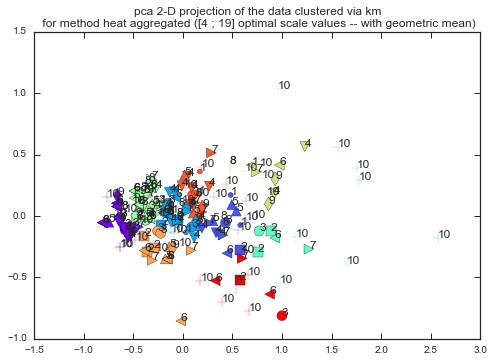

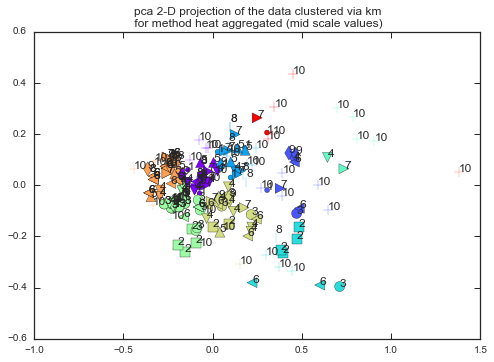

start= 0
start= 7
start= 14
start= 21
start= 28
start= 35
start= 42
start= 49
start= 56
start= 63
start= 70
start= 75
start= 80
start= 85
start= 90
start= 95
start= 100
start= 105
start= 110
start= 115
start= 120
start= 125
start= 130
start= 135
start= 140
start= 145
start= 150
start= 155
start= 160
start= 165
(0, 1)
[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47

2017-10-04 17:31:51,841:[INFO](pygsp.filters.filter.__init__): Heat : has to compute lmax
2017-10-04 17:31:51,856:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 17:31:51,908:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 17:31:51,952:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 17:31:51,996:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 17:31:52,040:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 17:31:52,086:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 17:31:52,136:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 17:31:52,196:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 17:31:52,268:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 17:31:52,377:[INFO](pygsp.filters.filter.analysis): The analysis method

Creating Vertex Features matrix
V is a 210 by 176 matrix.
Node-role matrix is of dimensions 210 by 10
[[  3813.              0.05869138     12.         ...,      0.00909686
       0.00909686     12.        ]
 [     0.              0.05851064      4.         ...,      0.00336567
       0.00336567      4.        ]
 [  5097.              0.06192593      8.         ...,      0.00641254
       0.00641254      8.        ]
 ..., 
 [ 24336.              0.0958276       6.         ...,      0.00530139
       0.00530139      6.        ]
 [ 22387.33333333      0.10528967      6.         ...,      0.00437188
       0.00437188      6.        ]
 [     0.              0.08330012      2.         ...,      0.00224457
       0.00224457      2.        ]]
[[ 0.          0.02842316  0.01889531  0.          0.          0.          0.
   0.01893404]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.19515367  0.10492893  0.1383291   0.09093563  0.06074684  0.138

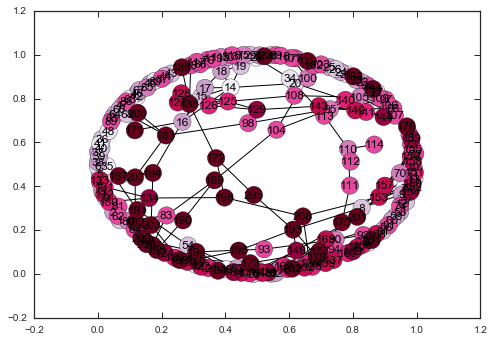

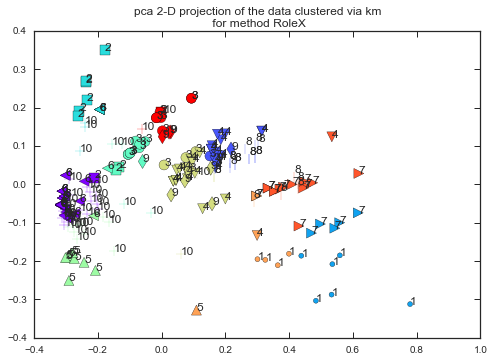

N is210
123
122
137
138
60
58
161
160
57
61
166
165
133
132
19
81
11
64
84
36
40
82
102
101
103
66
44
145
46
146
128
127
65
32
18
47
43
30
24
115
116
75
119
117
96
118
156
97
15
26
59
17
29
76
79
92
91
33
77
10
197
80
141
142
37
39
25
186
78
159
12
158
5
176
147
148
89
4
87
88
203
45
31
114
112
16
181
50
196
152
151
72
109
74
71
195
107
51
106
73
3
1
8
187
178
167
183
149
20
130
131
134
67
55
155
52
63
189
53
49
100
172
202
162
41
9
175
163
69
68
94
209
62
120
208
121
27
179
126
143
182
140
144
136
171
124
104
93
139
164
125
135
111
6
83
13
23
169
7
153
206
205
207
200
199
157
154
192
14
34
168
198
90
204
2
22
113
184
98
108
48
177
170
38
173
180
188
95
191
54
190
21
56
194
185
129
86
42
201
193
110
150
85
0
35
99
174
28
105
70
[[ 0.          3.41353503  2.41930819 ...,  2.6080475   2.94229395
   4.00616793]
 [ 3.41353503  0.          3.98921291 ...,  4.29662775  4.90020234
   5.12421332]
 [ 2.41930819  3.98921291  0.         ...,  1.95668439  2.99204169
   3.3554731 ]
 ..., 
 [ 2.6080

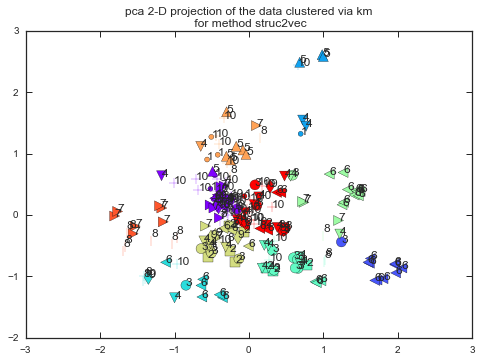

[[ 0.          0.20284187  0.15355082 ...,  0.19380029  0.17805205
   0.23256154]
 [ 0.20284187  0.          0.08809391 ...,  0.08955776  0.07979006
   0.07205581]
 [ 0.15355082  0.08809391  0.         ...,  0.08403678  0.0978433
   0.1371599 ]
 ..., 
 [ 0.19380029  0.08955776  0.08403678 ...,  0.          0.09770947
   0.12220789]
 [ 0.17805205  0.07979006  0.0978433  ...,  0.09770947  0.          0.12472924]
 [ 0.23256154  0.07205581  0.1371599  ...,  0.12220789  0.12472924  0.        ]]


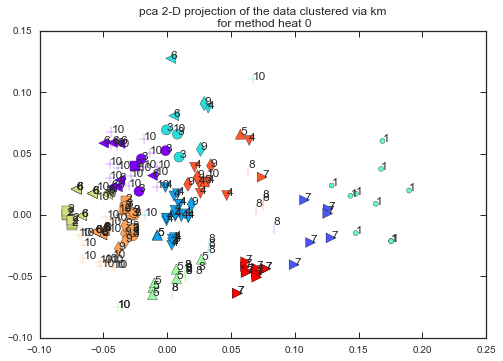

[[ 0.          0.17126598  0.11683308 ...,  0.19526518  0.30360948
   0.21237309]
 [ 0.17126598  0.          0.0870647  ...,  0.1032106   0.22803235
   0.10777775]
 [ 0.11683308  0.0870647   0.         ...,  0.10855696  0.2567712
   0.15116327]
 ..., 
 [ 0.19526518  0.1032106   0.10855696 ...,  0.          0.21056581
   0.17464238]
 [ 0.30360948  0.22803235  0.2567712  ...,  0.21056581  0.          0.30344055]
 [ 0.21237309  0.10777775  0.15116327 ...,  0.17464238  0.30344055  0.        ]]


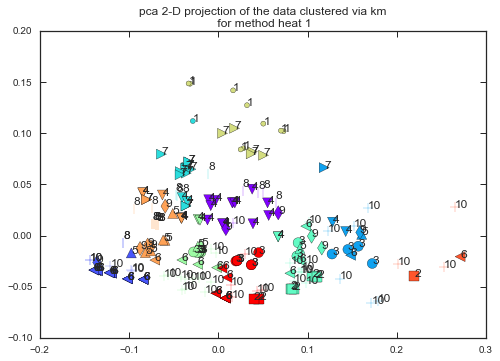

[[ 0.          0.1311843   0.07957488 ...,  0.18161678  0.36866763
   0.20943738]
 [ 0.1311843   0.          0.09847209 ...,  0.1284844   0.32815427
   0.14942391]
 [ 0.07957488  0.09847209  0.         ...,  0.13967763  0.35162799
   0.1780907 ]
 ..., 
 [ 0.18161678  0.1284844   0.13967763 ...,  0.          0.28555418
   0.18129718]
 [ 0.36866763  0.32815427  0.35162799 ...,  0.28555418  0.          0.41293827]
 [ 0.20943738  0.14942391  0.1780907  ...,  0.18129718  0.41293827  0.        ]]


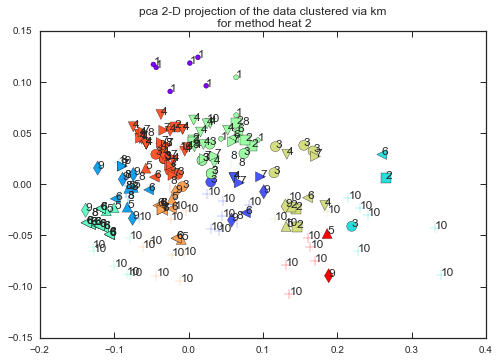

[[ 0.          0.11985599  0.11025759 ...,  0.21265514  0.37343671
   0.21717554]
 [ 0.11985599  0.          0.10574166 ...,  0.21596418  0.35500604
   0.18329793]
 [ 0.11025759  0.10574166  0.         ...,  0.18783578  0.35709016
   0.21396149]
 ..., 
 [ 0.21265514  0.21596418  0.18783578 ...,  0.          0.30189151
   0.18737486]
 [ 0.37343671  0.35500604  0.35709016 ...,  0.30189151  0.          0.41474245]
 [ 0.21717554  0.18329793  0.21396149 ...,  0.18737486  0.41474245  0.        ]]


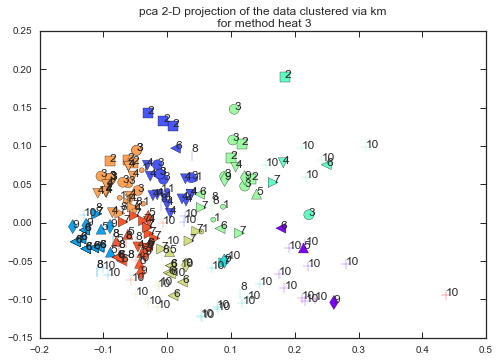

[[ 0.          0.11312241  0.13601393 ...,  0.28088627  0.36433864
   0.18839622]
 [ 0.11312241  0.          0.09082083 ...,  0.28862929  0.36078701
   0.2050763 ]
 [ 0.13601393  0.09082083  0.         ...,  0.27378893  0.35403668
   0.23487995]
 ..., 
 [ 0.28088627  0.28862929  0.27378893 ...,  0.          0.31631302
   0.20579623]
 [ 0.36433864  0.36078701  0.35403668 ...,  0.31631302  0.          0.38792317]
 [ 0.18839622  0.2050763   0.23487995 ...,  0.20579623  0.38792317  0.        ]]


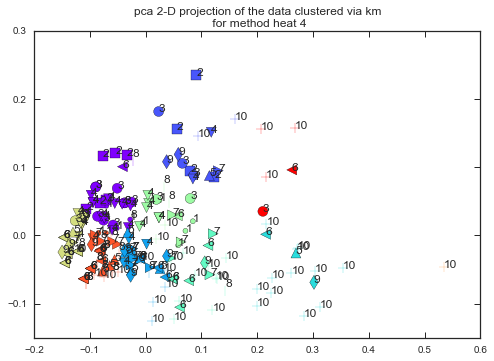

[[ 0.          0.16498538  0.14374613 ...,  0.33266613  0.3776286
   0.20883186]
 [ 0.16498538  0.          0.09419312 ...,  0.3587596   0.36596061
   0.23743382]
 [ 0.14374613  0.09419312  0.         ...,  0.34802162  0.3565787
   0.25166052]
 ..., 
 [ 0.33266613  0.3587596   0.34802162 ...,  0.          0.31361595
   0.20560953]
 [ 0.3776286   0.36596061  0.3565787  ...,  0.31361595  0.          0.36554572]
 [ 0.20883186  0.23743382  0.25166052 ...,  0.20560953  0.36554572  0.        ]]


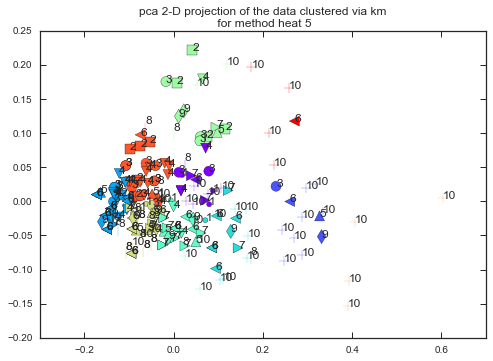

[[ 0.          0.15142623  0.13186087 ...,  0.37434013  0.36862988
   0.22876344]
 [ 0.15142623  0.          0.0743876  ...,  0.43000279  0.38103609
   0.26896426]
 [ 0.13186087  0.0743876   0.         ...,  0.41104766  0.36968892
   0.27671362]
 ..., 
 [ 0.37434013  0.43000279  0.41104766 ...,  0.          0.28403285
   0.23527251]
 [ 0.36862988  0.38103609  0.36968892 ...,  0.28403285  0.          0.31687098]
 [ 0.22876344  0.26896426  0.27671362 ...,  0.23527251  0.31687098  0.        ]]


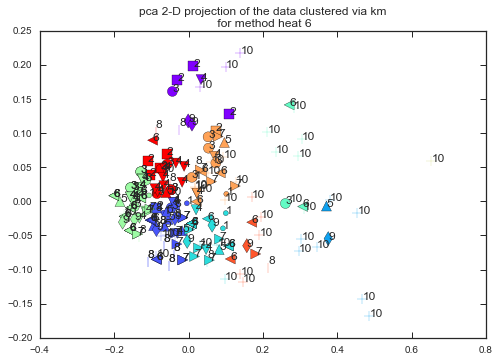

[[ 0.          0.14906451  0.12088986 ...,  0.43048815  0.38359533
   0.23992123]
 [ 0.14906451  0.          0.09895217 ...,  0.49988413  0.4139036
   0.28272039]
 [ 0.12088986  0.09895217  0.         ...,  0.47895567  0.41002468
   0.28646596]
 ..., 
 [ 0.43048815  0.49988413  0.47895567 ...,  0.          0.25976092
   0.26764457]
 [ 0.38359533  0.4139036   0.41002468 ...,  0.25976092  0.          0.28230516]
 [ 0.23992123  0.28272039  0.28646596 ...,  0.26764457  0.28230516  0.        ]]


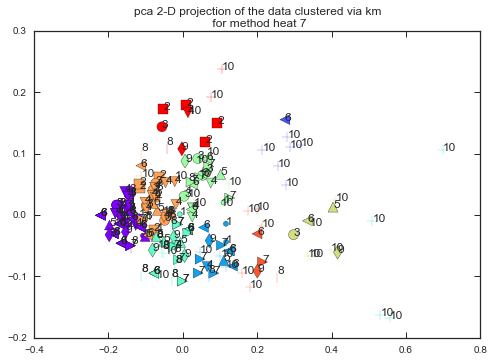

[[ 0.          0.15606006  0.11292833 ...,  0.46592416  0.41305588
   0.26405818]
 [ 0.15606006  0.          0.11901998 ...,  0.53665145  0.46543854
   0.32204366]
 [ 0.11292833  0.11901998  0.         ...,  0.50834444  0.45041746
   0.3075051 ]
 ..., 
 [ 0.46592416  0.53665145  0.50834444 ...,  0.          0.21321956
   0.26550405]
 [ 0.41305588  0.46543854  0.45041746 ...,  0.21321956  0.          0.27098145]
 [ 0.26405818  0.32204366  0.3075051  ...,  0.26550405  0.27098145  0.        ]]


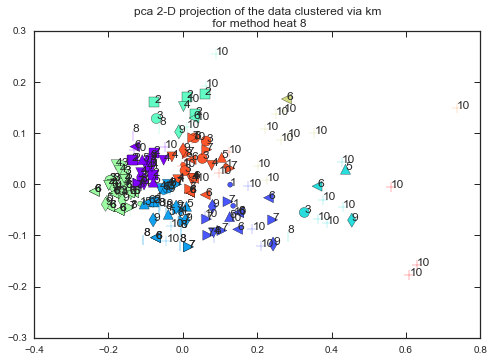

[[ 0.          0.15910763  0.10837563 ...,  0.4913529   0.4546278
   0.29006025]
 [ 0.15910763  0.          0.12325132 ...,  0.5644788   0.51997688
   0.35173801]
 [ 0.10837563  0.12325132  0.         ...,  0.52535177  0.48936509
   0.32608137]
 ..., 
 [ 0.4913529   0.5644788   0.52535177 ...,  0.          0.20644744
   0.27066969]
 [ 0.4546278   0.51997688  0.48936509 ...,  0.20644744  0.          0.27211563]
 [ 0.29006025  0.35173801  0.32608137 ...,  0.27066969  0.27211563  0.        ]]


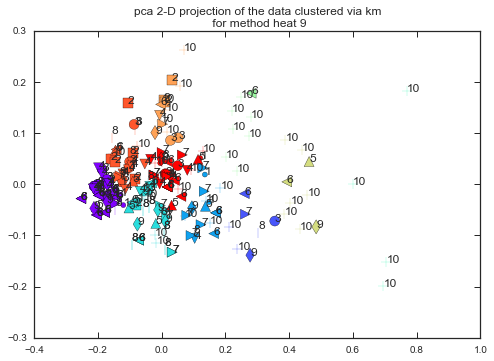

[[ 0.          0.16092726  0.10572549 ...,  0.52474589  0.4918662
   0.30599937]
 [ 0.16092726  0.          0.11896657 ...,  0.60201681  0.56102191
   0.36625843]
 [ 0.10572549  0.11896657  0.         ...,  0.55503889  0.52061333
   0.33671382]
 ..., 
 [ 0.52474589  0.60201681  0.55503889 ...,  0.          0.22919467
   0.29395672]
 [ 0.4918662   0.56102191  0.52061333 ...,  0.22919467  0.          0.28477643]
 [ 0.30599937  0.36625843  0.33671382 ...,  0.29395672  0.28477643  0.        ]]


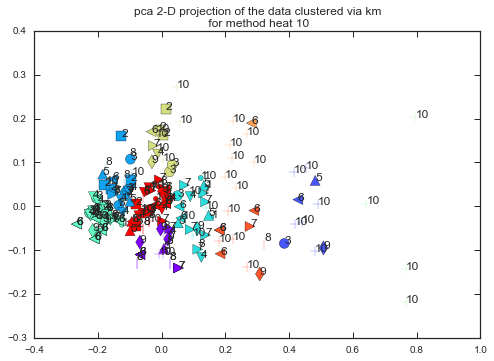

[[ 0.          0.16382107  0.10375534 ...,  0.55849471  0.51962694
   0.32042925]
 [ 0.16382107  0.          0.11272269 ...,  0.63991893  0.5895922
   0.38186812]
 [ 0.10375534  0.11272269  0.         ...,  0.58935677  0.54459332
   0.3497929 ]
 ..., 
 [ 0.55849471  0.63991893  0.58935677 ...,  0.          0.24526901
   0.31344687]
 [ 0.51962694  0.5895922   0.54459332 ...,  0.24526901  0.          0.29860023]
 [ 0.32042925  0.38186812  0.3497929  ...,  0.31344687  0.29860023  0.        ]]


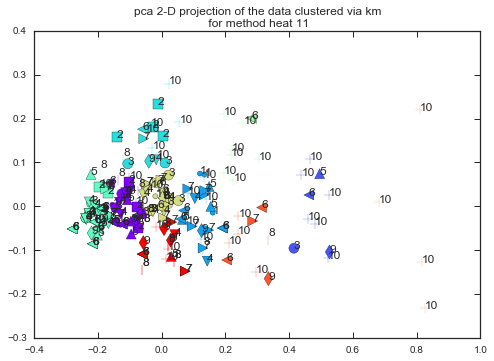

[[ 0.          0.16812129  0.10287487 ...,  0.58724366  0.54094975
   0.33938158]
 [ 0.16812129  0.          0.10796213 ...,  0.67283829  0.61145501
   0.40446047]
 [ 0.10287487  0.10796213  0.         ...,  0.6207507   0.56450936
   0.36919066]
 ..., 
 [ 0.58724366  0.67283829  0.6207507  ...,  0.          0.25113543
   0.32367108]
 [ 0.54094975  0.61145501  0.56450936 ...,  0.25113543  0.          0.30638842]
 [ 0.33938158  0.40446047  0.36919066 ...,  0.32367108  0.30638842  0.        ]]


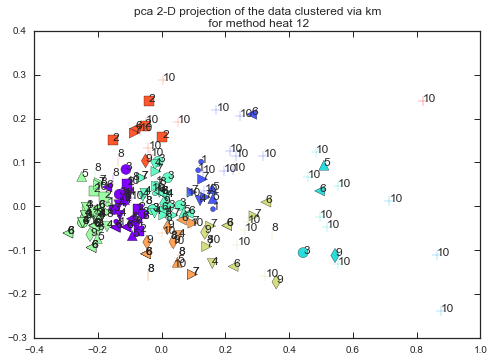

[[ 0.          0.17337746  0.10352724 ...,  0.61292658  0.55935818
   0.36204399]
 [ 0.17337746  0.          0.10568651 ...,  0.70269118  0.63040135
   0.43040449]
 [ 0.10352724  0.10568651  0.         ...,  0.64925503  0.58249042
   0.39198767]
 ..., 
 [ 0.61292658  0.70269118  0.64925503 ...,  0.          0.25265908
   0.33069655]
 [ 0.55935818  0.63040135  0.58249042 ...,  0.25265908  0.          0.30815156]
 [ 0.36204399  0.43040449  0.39198767 ...,  0.33069655  0.30815156  0.        ]]


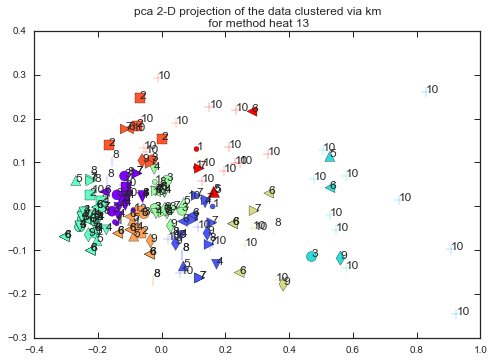

[[ 0.          0.17891827  0.10547444 ...,  0.63820378  0.57688791
   0.3860764 ]
 [ 0.17891827  0.          0.10554617 ...,  0.7315821   0.64795111
   0.45540351]
 [ 0.10547444  0.10554617  0.         ...,  0.67638849  0.59934577
   0.4147052 ]
 ..., 
 [ 0.63820378  0.7315821   0.67638849 ...,  0.          0.2530095
   0.33968071]
 [ 0.57688791  0.64795111  0.59934577 ...,  0.2530095   0.          0.30681919]
 [ 0.3860764   0.45540351  0.4147052  ...,  0.33968071  0.30681919  0.        ]]


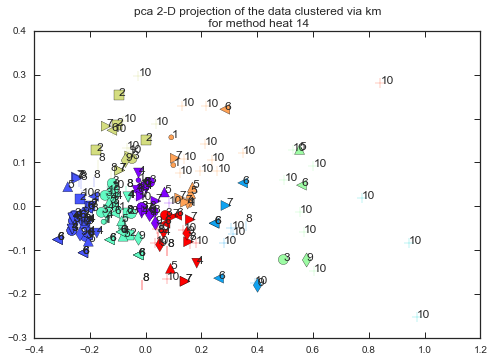

[[ 0.          0.1841109   0.10809655 ...,  0.66399349  0.59444598
   0.41026136]
 [ 0.1841109   0.          0.10676028 ...,  0.75967367  0.66447763
   0.4775684 ]
 [ 0.10809655  0.10676028  0.         ...,  0.70251575  0.61525521
   0.43568541]
 ..., 
 [ 0.66399349  0.75967367  0.70251575 ...,  0.          0.25287397
   0.35187731]
 [ 0.59444598  0.66447763  0.61525521 ...,  0.25287397  0.          0.30497791]
 [ 0.41026136  0.4775684   0.43568541 ...,  0.35187731  0.30497791  0.        ]]


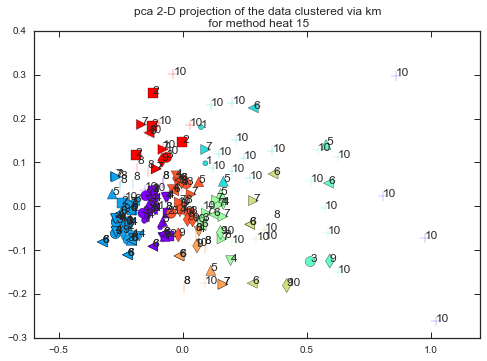

[[ 0.          0.18851019  0.11083716 ...,  0.69016277  0.61239668
   0.43441405]
 [ 0.18851019  0.          0.10862514 ...,  0.78628533  0.68000459
   0.49673251]
 [ 0.11083716  0.10862514  0.         ...,  0.72731602  0.63025338
   0.45467458]
 ..., 
 [ 0.69016277  0.78628533  0.72731602 ...,  0.          0.25263617
   0.36647545]
 [ 0.61239668  0.68000459  0.63025338 ...,  0.25263617  0.          0.30393727]
 [ 0.43441405  0.49673251  0.45467458 ...,  0.36647545  0.30393727  0.        ]]


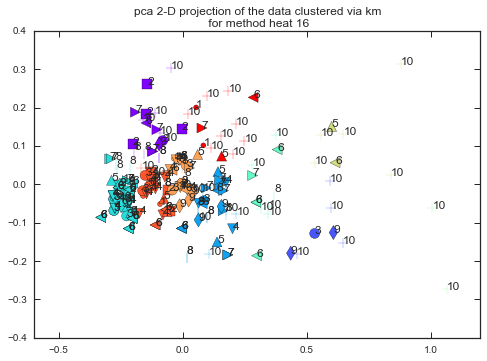

[[ 0.          0.19191774  0.11341833 ...,  0.71646915  0.63090642
   0.45877698]
 [ 0.19191774  0.          0.11066488 ...,  0.81098164  0.6945431
   0.51336877]
 [ 0.11341833  0.11066488  0.         ...,  0.75058761  0.64441725
   0.47199966]
 ..., 
 [ 0.71646915  0.81098164  0.75058761 ...,  0.          0.25308136
   0.38253099]
 [ 0.63090642  0.6945431   0.64441725 ...,  0.25308136  0.          0.30402145]
 [ 0.45877698  0.51336877  0.47199966 ...,  0.38253099  0.30402145  0.        ]]


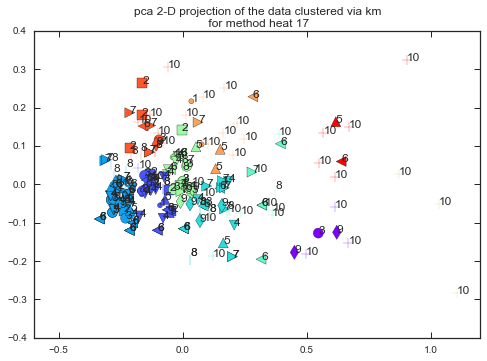

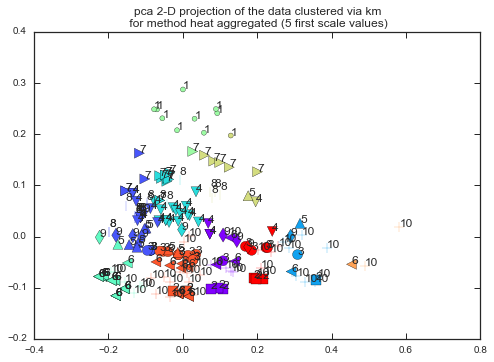

smax= 18  and smin= 5


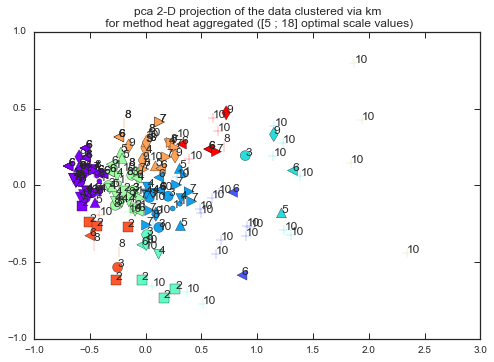

smax= 19  and smin= 5


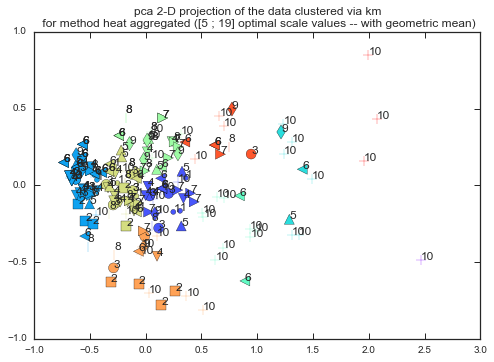

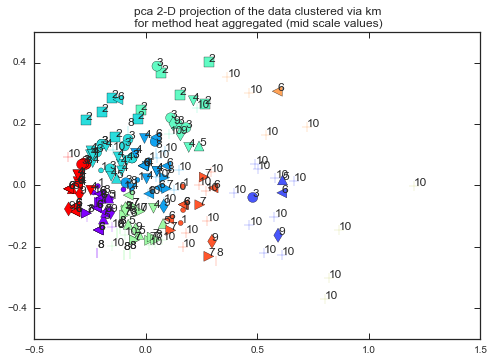

start= 0
start= 7
start= 14
start= 21
start= 28
start= 35
start= 42
start= 49
start= 56
start= 63
start= 70
start= 75
start= 80
start= 85
start= 90
start= 95
start= 100
start= 105
start= 110
start= 115
start= 120
start= 125
start= 130
start= 135
start= 140
start= 145
start= 150
start= 155
start= 160
start= 165
(0, 15)
[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 4

2017-10-04 17:44:18,260:[INFO](pygsp.filters.filter.__init__): Heat : has to compute lmax
2017-10-04 17:44:18,332:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 17:44:18,471:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 17:44:18,519:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 17:44:18,575:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 17:44:18,622:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 17:44:18,677:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 17:44:18,778:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 17:44:18,862:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 17:44:18,972:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 17:44:19,054:[INFO](pygsp.filters.filter.analysis): The analysis method

Creating Vertex Features matrix
V is a 210 by 180 matrix.
Node-role matrix is of dimensions 210 by 10
[[  1013.              0.07256944     12.         ...,      0.00947206
       0.00947206     12.        ]
 [     0.              0.06770327      4.         ...,      0.00343464
       0.00343464      4.        ]
 [    22.              0.06818923      6.         ...,      0.00486523
       0.00486523      6.        ]
 ..., 
 [  5115.              0.05818486      6.         ...,      0.00607376
       0.00607376      6.        ]
 [  5460.              0.07669725      4.         ...,      0.00368748
       0.00368748      4.        ]
 [ 18520.              0.06994645      6.         ...,      0.00556476
       0.00556476      6.        ]]
[[ 0.          0.01239953  0.          0.00702557  0.          0.          0.
   0.        ]
 [ 0.          0.          0.00322171  0.02355496  0.04028569  0.          0.
   0.00320052]
 [ 0.          0.05876422  0.          0.06528757  0.05162869  0.   

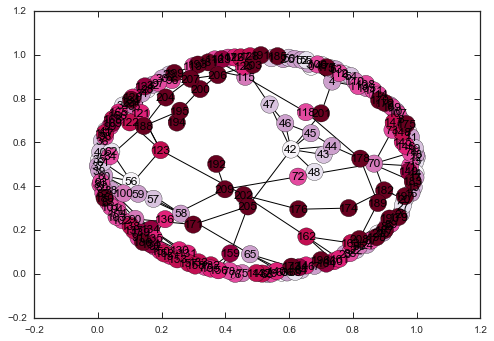

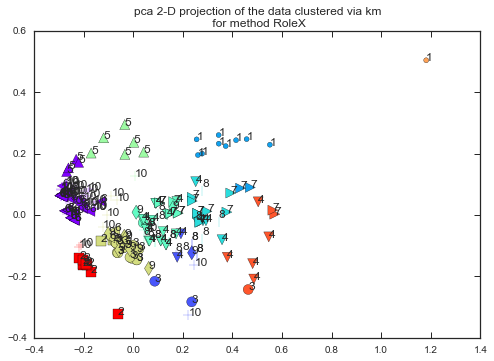

N is210
71
74
168
167
57
59
108
107
109
160
161
156
155
45
43
18
120
99
98
97
121
138
137
29
102
61
103
104
101
158
157
19
26
128
64
25
83
82
8
12
54
50
142
143
65
34
40
60
126
41
116
117
145
146
94
93
92
151
133
51
150
132
9
11
53
88
89
86
66
22
46
68
15
17
24
47
79
77
162
129
76
123
169
159
189
183
33
31
113
111
16
139
165
30
171
0
122
37
201
105
35
163
52
144
10
205
62
186
152
84
195
170
55
153
164
177
13
114
176
140
127
187
172
174
106
188
23
206
204
200
1
166
69
7
3
207
194
95
80
4
6
48
125
192
49
32
124
72
112
63
203
78
27
185
118
119
73
39
184
5
21
136
190
36
197
110
81
2
193
96
148
38
208
198
209
199
115
178
181
179
147
67
87
135
14
56
131
28
58
91
130
149
202
134
182
154
44
20
196
75
70
85
100
141
175
173
180
90
191
42
[[ 0.          4.68411146  4.70845521 ...,  5.13331558  4.5162158
   4.26282569]
 [ 4.68411146  0.          1.50185767 ...,  3.93736789  3.19198025
   3.09325191]
 [ 4.70845521  1.50185767  0.         ...,  3.69763959  2.75318072
   2.9996786 ]
 ..., 
 [ 5.13331

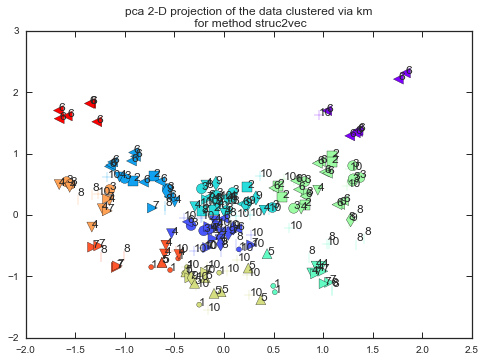

[[ 0.          0.15533961  0.11849507 ...,  0.15584794  0.16956668
   0.13456158]
 [ 0.15533961  0.          0.04961061 ...,  0.10528011  0.06265303
   0.07794956]
 [ 0.11849507  0.04961061  0.         ...,  0.1126314   0.09091986
   0.07553089]
 ..., 
 [ 0.15584794  0.10528011  0.1126314  ...,  0.          0.08850793
   0.11856499]
 [ 0.16956668  0.06265303  0.09091986 ...,  0.08850793  0.          0.09733419]
 [ 0.13456158  0.07794956  0.07553089 ...,  0.11856499  0.09733419  0.        ]]


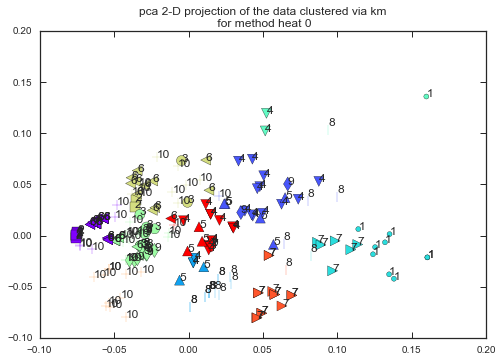

[[ 0.          0.13656249  0.12268949 ...,  0.156224    0.14180103
   0.13704114]
 [ 0.13656249  0.          0.07680712 ...,  0.13697202  0.08465871
   0.13059698]
 [ 0.12268949  0.07680712  0.         ...,  0.10935256  0.0941023
   0.12294978]
 ..., 
 [ 0.156224    0.13697202  0.10935256 ...,  0.          0.11460885
   0.15261338]
 [ 0.14180103  0.08465871  0.0941023  ...,  0.11460885  0.          0.11590247]
 [ 0.13704114  0.13059698  0.12294978 ...,  0.15261338  0.11590247  0.        ]]


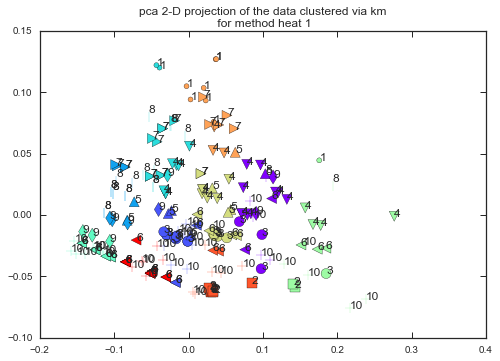

[[ 0.          0.16656831  0.15963518 ...,  0.14813836  0.1512139
   0.14346577]
 [ 0.16656831  0.          0.07925257 ...,  0.15559565  0.10181955
   0.16015548]
 [ 0.15963518  0.07925257  0.         ...,  0.13977625  0.10540366
   0.15473771]
 ..., 
 [ 0.14813836  0.15559565  0.13977625 ...,  0.          0.10643625
   0.14879027]
 [ 0.1512139   0.10181955  0.10540366 ...,  0.10643625  0.          0.13621619]
 [ 0.14346577  0.16015548  0.15473771 ...,  0.14879027  0.13621619  0.        ]]


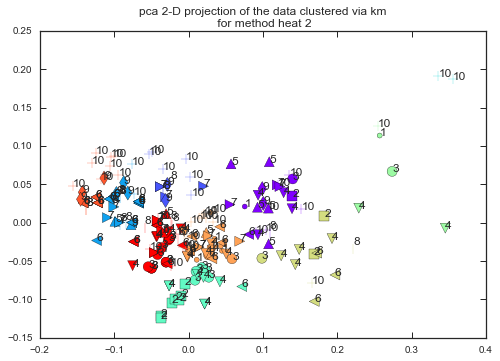

[[ 0.          0.18826003  0.18392337 ...,  0.15823635  0.15234445
   0.15518959]
 [ 0.18826003  0.          0.07329021 ...,  0.22857973  0.14714225
   0.16083122]
 [ 0.18392337  0.07329021  0.         ...,  0.21236347  0.12735804
   0.1666835 ]
 ..., 
 [ 0.15823635  0.22857973  0.21236347 ...,  0.          0.13419732
   0.1671539 ]
 [ 0.15234445  0.14714225  0.12735804 ...,  0.13419732  0.          0.13905198]
 [ 0.15518959  0.16083122  0.1666835  ...,  0.1671539   0.13905198  0.        ]]


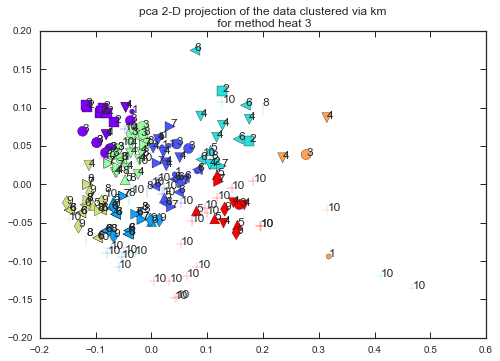

[[ 0.          0.19428137  0.18221004 ...,  0.18423224  0.15141928
   0.1560872 ]
 [ 0.19428137  0.          0.08019925 ...,  0.26656936  0.16602055
   0.17025238]
 [ 0.18221004  0.08019925  0.         ...,  0.22347314  0.1223634
   0.15150582]
 ..., 
 [ 0.18423224  0.26656936  0.22347314 ...,  0.          0.13091762
   0.1652892 ]
 [ 0.15141928  0.16602055  0.1223634  ...,  0.13091762  0.          0.10279671]
 [ 0.1560872   0.17025238  0.15150582 ...,  0.1652892   0.10279671  0.        ]]


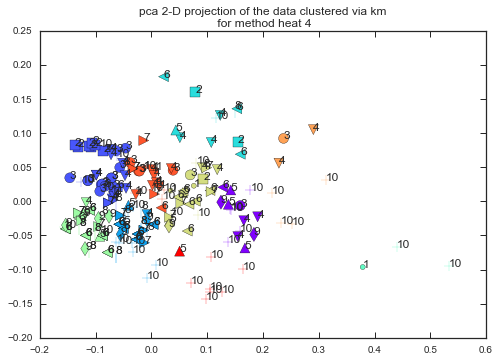

[[ 0.          0.18915726  0.15787594 ...,  0.20959472  0.1382008
   0.14538265]
 [ 0.18915726  0.          0.1230666  ...,  0.29379329  0.19862701
   0.17861872]
 [ 0.15787594  0.1230666   0.         ...,  0.2309644   0.12910673
   0.13763146]
 ..., 
 [ 0.20959472  0.29379329  0.2309644  ...,  0.          0.1298694
   0.17543008]
 [ 0.1382008   0.19862701  0.12910673 ...,  0.1298694   0.          0.10306347]
 [ 0.14538265  0.17861872  0.13763146 ...,  0.17543008  0.10306347  0.        ]]


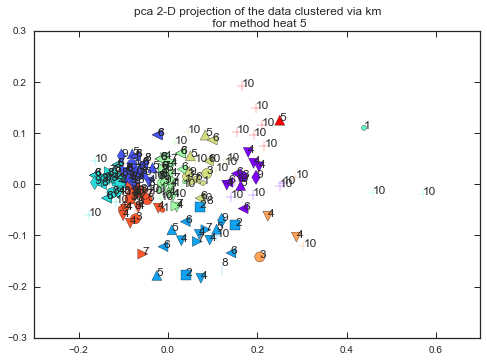

[[ 0.          0.18163809  0.14902179 ...,  0.22037225  0.12869299
   0.1364802 ]
 [ 0.18163809  0.          0.11872227 ...,  0.30188976  0.19962807
   0.17602043]
 [ 0.14902179  0.11872227  0.         ...,  0.23198469  0.14211829
   0.13104277]
 ..., 
 [ 0.22037225  0.30188976  0.23198469 ...,  0.          0.12867067
   0.17417976]
 [ 0.12869299  0.19962807  0.14211829 ...,  0.12867067  0.          0.09915956]
 [ 0.1364802   0.17602043  0.13104277 ...,  0.17417976  0.09915956  0.        ]]


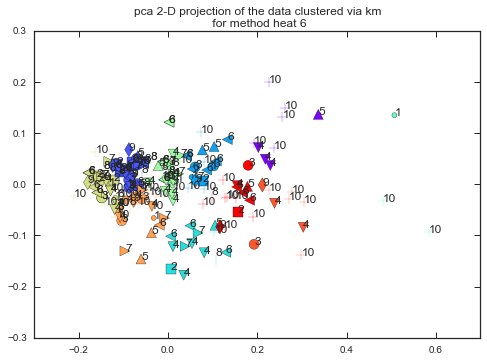

[[ 0.          0.19945866  0.15476322 ...,  0.23647395  0.16480781
   0.14883417]
 [ 0.19945866  0.          0.09375188 ...,  0.29311672  0.19131548
   0.16543129]
 [ 0.15476322  0.09375188  0.         ...,  0.23776019  0.14062232
   0.13092223]
 ..., 
 [ 0.23647395  0.29311672  0.23776019 ...,  0.          0.14329341
   0.17326534]
 [ 0.16480781  0.19131548  0.14062232 ...,  0.14329341  0.          0.09512935]
 [ 0.14883417  0.16543129  0.13092223 ...,  0.17326534  0.09512935  0.        ]]


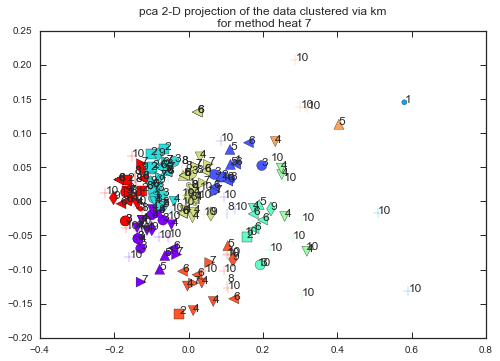

[[ 0.          0.21346097  0.16342658 ...,  0.26919409  0.18080546
   0.17609721]
 [ 0.21346097  0.          0.09638221 ...,  0.29883838  0.18868775
   0.16844199]
 [ 0.16342658  0.09638221  0.         ...,  0.24775693  0.14143681
   0.12220859]
 ..., 
 [ 0.26919409  0.29883838  0.24775693 ...,  0.          0.1708125
   0.19443339]
 [ 0.18080546  0.18868775  0.14143681 ...,  0.1708125   0.          0.09830083]
 [ 0.17609721  0.16844199  0.12220859 ...,  0.19443339  0.09830083  0.        ]]


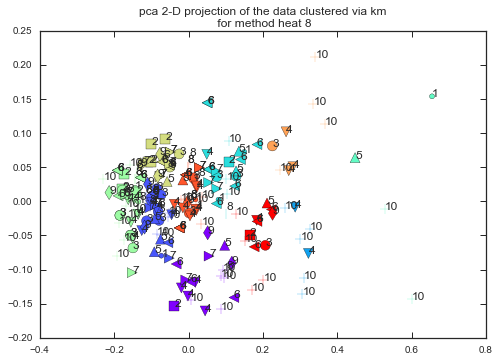

[[ 0.          0.22625741  0.1627767  ...,  0.31182761  0.18580394
   0.20111767]
 [ 0.22625741  0.          0.10473168 ...,  0.31872162  0.17992818
   0.19247694]
 [ 0.1627767   0.10473168  0.         ...,  0.27674814  0.1425577
   0.12174089]
 ..., 
 [ 0.31182761  0.31872162  0.27674814 ...,  0.          0.20398351
   0.22630376]
 [ 0.18580394  0.17992818  0.1425577  ...,  0.20398351  0.          0.13644087]
 [ 0.20111767  0.19247694  0.12174089 ...,  0.22630376  0.13644087  0.        ]]


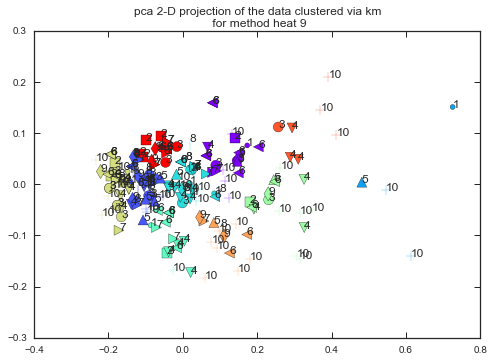

[[ 0.          0.24114808  0.15989888 ...,  0.33707905  0.20533189
   0.18945729]
 [ 0.24114808  0.          0.11318757 ...,  0.32933619  0.17652947
   0.1954428 ]
 [ 0.15989888  0.11318757  0.         ...,  0.30737344  0.15558835
   0.11862869]
 ..., 
 [ 0.33707905  0.32933619  0.30737344 ...,  0.          0.21046622
   0.2478541 ]
 [ 0.20533189  0.17652947  0.15558835 ...,  0.21046622  0.          0.14904163]
 [ 0.18945729  0.1954428   0.11862869 ...,  0.2478541   0.14904163  0.        ]]


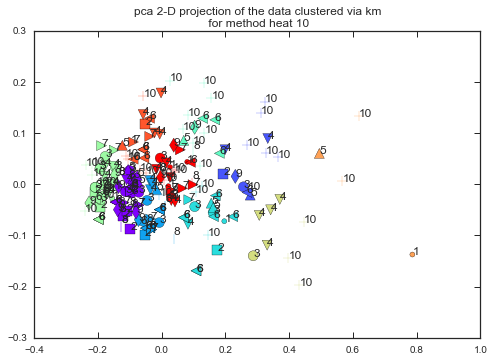

[[ 0.          0.25462933  0.16455462 ...,  0.34346497  0.21400388
   0.175477  ]
 [ 0.25462933  0.          0.1209182  ...,  0.32558397  0.17476315
   0.17376481]
 [ 0.16455462  0.1209182   0.         ...,  0.32534153  0.16745139
   0.1166977 ]
 ..., 
 [ 0.34346497  0.32558397  0.32534153 ...,  0.          0.20485193
   0.23597592]
 [ 0.21400388  0.17476315  0.16745139 ...,  0.20485193  0.          0.11489624]
 [ 0.175477    0.17376481  0.1166977  ...,  0.23597592  0.11489624  0.        ]]


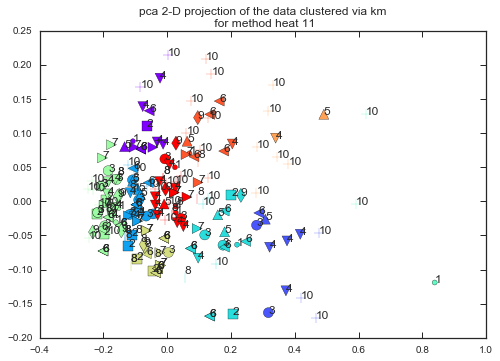

[[ 0.          0.26340869  0.17658523 ...,  0.34049576  0.20823781
   0.18798143]
 [ 0.26340869  0.          0.12677072 ...,  0.31516625  0.17226098
   0.16163964]
 [ 0.17658523  0.12677072  0.         ...,  0.33084144  0.17237004
   0.14565971]
 ..., 
 [ 0.34049576  0.31516625  0.33084144 ...,  0.          0.21185087
   0.20404248]
 [ 0.20823781  0.17226098  0.17237004 ...,  0.21185087  0.          0.08729793]
 [ 0.18798143  0.16163964  0.14565971 ...,  0.20404248  0.08729793  0.        ]]


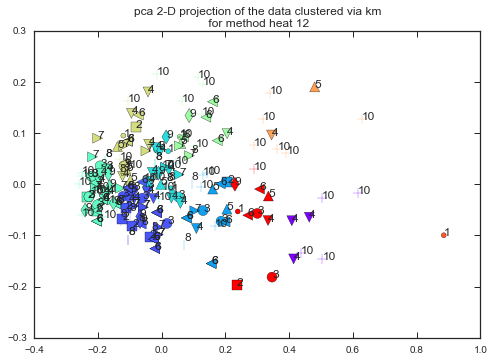

[[ 0.          0.26727411  0.19029398 ...,  0.33558542  0.20096393
   0.20402372]
 [ 0.26727411  0.          0.1299707  ...,  0.30595512  0.17068032
   0.16938905]
 [ 0.19029398  0.1299707   0.         ...,  0.32877062  0.17294144
   0.182899  ]
 ..., 
 [ 0.33558542  0.30595512  0.32877062 ...,  0.          0.2332511
   0.18590423]
 [ 0.20096393  0.17068032  0.17294144 ...,  0.2332511   0.          0.11102015]
 [ 0.20402372  0.16938905  0.182899   ...,  0.18590423  0.11102015  0.        ]]


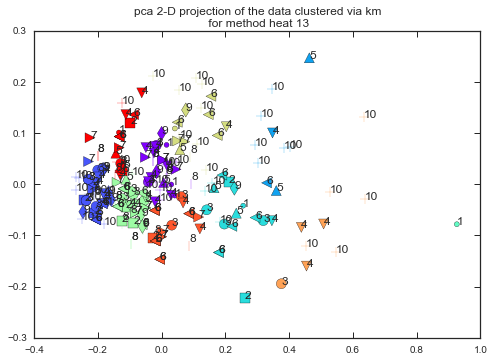

[[ 0.          0.26831222  0.20151835 ...,  0.3324374   0.201516
   0.20877038]
 [ 0.26831222  0.          0.13033751 ...,  0.30188553  0.17047839
   0.18005937]
 [ 0.20151835  0.13033751  0.         ...,  0.32370362  0.17172919
   0.2047305 ]
 ..., 
 [ 0.3324374   0.30188553  0.32370362 ...,  0.          0.25831356
   0.19446298]
 [ 0.201516    0.17047839  0.17172919 ...,  0.25831356  0.          0.14601557]
 [ 0.20877038  0.18005937  0.2047305  ...,  0.19446298  0.14601557  0.        ]]


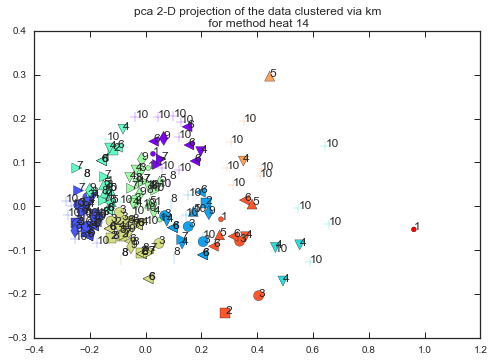

[[ 0.          0.26908365  0.20887263 ...,  0.33255164  0.20972866
   0.20601392]
 [ 0.26908365  0.          0.12829372 ...,  0.30354512  0.17061209
   0.18320033]
 [ 0.20887263  0.12829372  0.         ...,  0.31890815  0.16964342
   0.20749406]
 ..., 
 [ 0.33255164  0.30354512  0.31890815 ...,  0.          0.28014348
   0.21453173]
 [ 0.20972866  0.17061209  0.16964342 ...,  0.28014348  0.          0.1685209 ]
 [ 0.20601392  0.18320033  0.20749406 ...,  0.21453173  0.1685209   0.        ]]


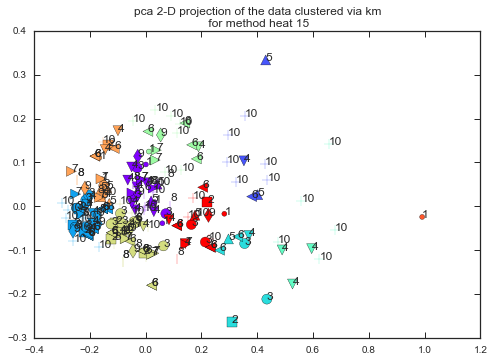

[[ 0.          0.27118555  0.21245583 ...,  0.33623046  0.22055793
   0.20251178]
 [ 0.27118555  0.          0.12476237 ...,  0.30986095  0.17010656
   0.17927846]
 [ 0.21245583  0.12476237  0.         ...,  0.31649039  0.16688384
   0.19638049]
 ..., 
 [ 0.33623046  0.30986095  0.31649039 ...,  0.          0.2972456
   0.23225472]
 [ 0.22055793  0.17010656  0.16688384 ...,  0.2972456   0.          0.17848543]
 [ 0.20251178  0.17927846  0.19638049 ...,  0.23225472  0.17848543  0.        ]]


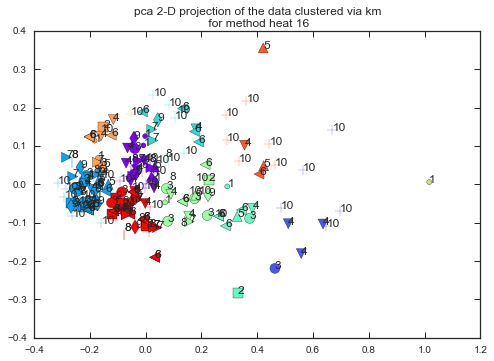

[[ 0.          0.27480091  0.21281098 ...,  0.34303126  0.2295194
   0.20113896]
 [ 0.27480091  0.          0.12093283 ...,  0.3193659   0.16869418
   0.17261761]
 [ 0.21281098  0.12093283  0.         ...,  0.3176202   0.16361055
   0.1783444 ]
 ..., 
 [ 0.34303126  0.3193659   0.3176202  ...,  0.          0.31063817
   0.24408088]
 [ 0.2295194   0.16869418  0.16361055 ...,  0.31063817  0.          0.18075903]
 [ 0.20113896  0.17261761  0.1783444  ...,  0.24408088  0.18075903  0.        ]]


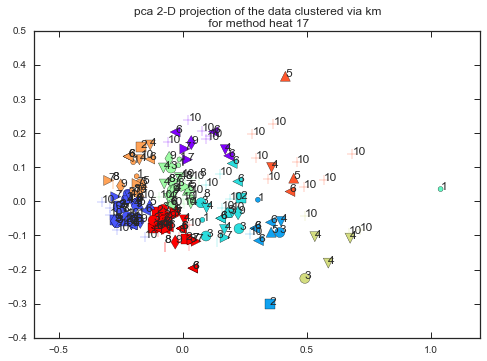

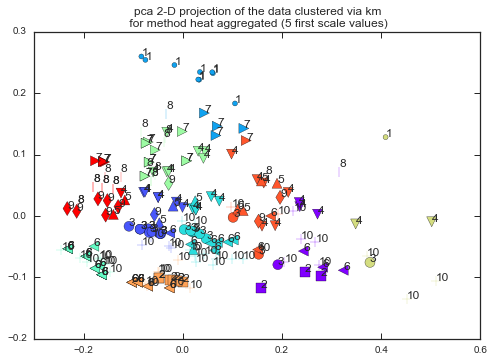

smax= 18  and smin= 5


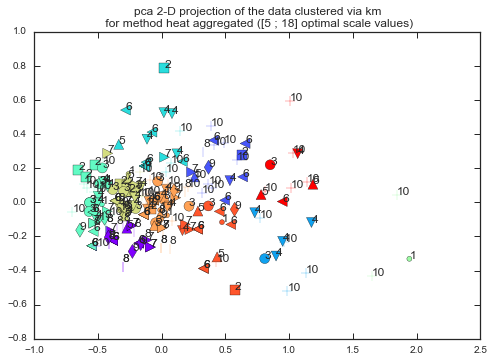

smax= 19  and smin= 6


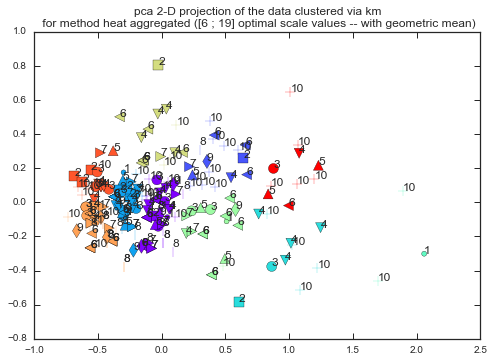

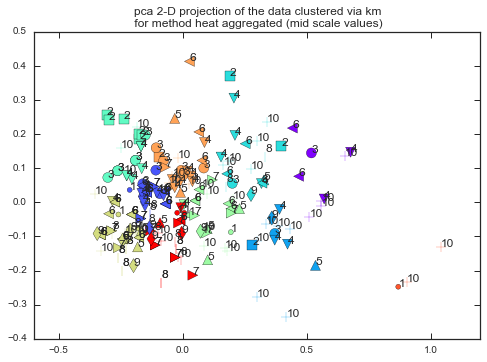

start= 0
start= 7
start= 14
start= 21
start= 28
start= 35
start= 42
start= 49
start= 56
start= 63
start= 70
start= 75
start= 80
start= 85
start= 90
start= 95
start= 100
start= 105
start= 110
start= 115
start= 120
start= 125
start= 130
start= 135
start= 140
start= 145
start= 150
start= 155
start= 160
start= 165
(0, 1)
[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47

2017-10-04 18:08:23,149:[INFO](pygsp.filters.filter.__init__): Heat : has to compute lmax
2017-10-04 18:08:23,204:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 18:08:23,407:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 18:08:23,607:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 18:08:23,730:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 18:08:23,867:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 18:08:24,010:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 18:08:24,143:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 18:08:24,266:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 18:08:24,428:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 18:08:24,821:[INFO](pygsp.filters.filter.analysis): The analysis method

Creating Vertex Features matrix
V is a 210 by 183 matrix.
Node-role matrix is of dimensions 210 by 10
[[  6354.              0.0934287      12.         ...,      0.0091189
       0.0091189      12.        ]
 [     0.              0.09268293      4.         ...,      0.00328313
       0.00328313      4.        ]
 [ 18809.              0.10121065     10.         ...,      0.00751177
       0.00751177     10.        ]
 ..., 
 [  3016.              0.09613615     10.         ...,      0.00758187
       0.00758187     10.        ]
 [  8228.              0.09098825      4.         ...,      0.00368538
       0.00368538      4.        ]
 [     0.              0.05875738      2.         ...,      0.00231083
       0.00231083      2.        ]]
[[ 0.          0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.07947447  0.05622603  0.          0.          0.0022697
   0.00228676  0.05619842]
 [ 0.          0.          0.          0.          0.         

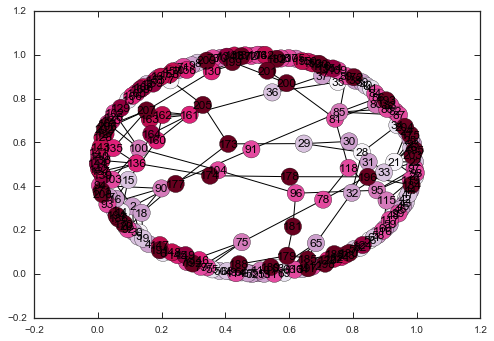

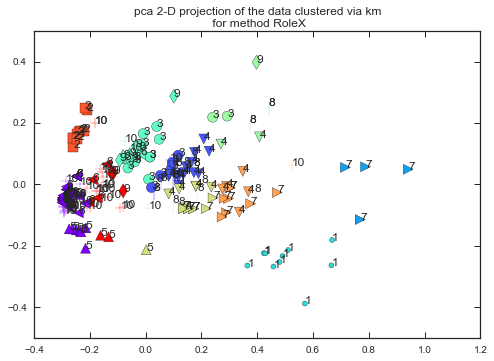

N is210
141
140
3
1
5
4
158
157
97
98
9
99
11
8
12
117
116
83
82
84
138
121
137
133
132
73
74
66
64
107
143
68
122
185
191
54
109
162
163
106
10
79
150
77
151
76
92
93
125
52
87
61
86
126
88
50
168
167
44
202
206
205
67
29
53
165
166
111
112
62
159
148
114
113
25
139
19
145
17
43
40
24
58
38
39
26
187
31
60
45
123
193
33
195
192
189
155
134
209
188
46
101
120
152
27
172
175
42
127
102
23
22
69
184
55
131
80
200
48
21
57
156
56
28
124
96
128
30
6
2
173
13
144
7
194
104
119
32
41
94
47
103
197
49
183
129
154
179
16
18
108
186
147
208
178
34
149
181
118
78
135
36
153
180
130
190
174
196
71
169
115
65
51
170
142
37
72
89
75
95
201
164
203
20
59
171
15
199
63
207
110
0
100
177
91
198
176
81
105
204
136
146
70
161
160
182
85
90
14
35
[[ 0.          3.21051103  3.73169475 ...,  3.49107825  2.43623019
   4.14983223]
 [ 3.21051103  0.          3.99293317 ...,  4.68272794  3.8766179
   4.82731997]
 [ 3.73169475  3.99293317  0.         ...,  4.27009737  2.8696579
   5.22210179]
 ..., 
 [ 3.491078

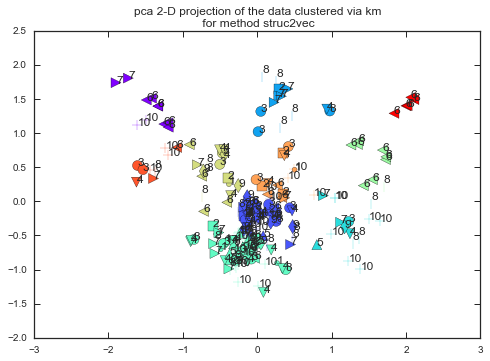

[[ 0.          0.19281031  0.10567918 ...,  0.20558942  0.19277991
   0.21280929]
 [ 0.19281031  0.          0.13164532 ...,  0.17201169  0.05770936
   0.08695394]
 [ 0.10567918  0.13164532  0.         ...,  0.1604952   0.14428081
   0.18023889]
 ..., 
 [ 0.20558942  0.17201169  0.1604952  ...,  0.          0.16384073
   0.1841656 ]
 [ 0.19277991  0.05770936  0.14428081 ...,  0.16384073  0.          0.0524652 ]
 [ 0.21280929  0.08695394  0.18023889 ...,  0.1841656   0.0524652   0.        ]]


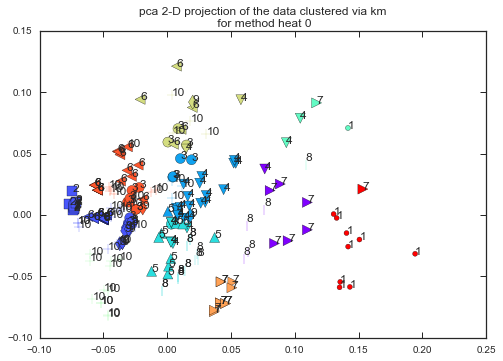

[[ 0.          0.15316792  0.15661299 ...,  0.30957803  0.16400211
   0.19447471]
 [ 0.15316792  0.          0.15299934 ...,  0.25398387  0.09341968
   0.14432013]
 [ 0.15661299  0.15299934  0.         ...,  0.22172178  0.16669332
   0.25126838]
 ..., 
 [ 0.30957803  0.25398387  0.22172178 ...,  0.          0.25252305
   0.33752517]
 [ 0.16400211  0.09341968  0.16669332 ...,  0.25252305  0.          0.11169941]
 [ 0.19447471  0.14432013  0.25126838 ...,  0.33752517  0.11169941  0.        ]]


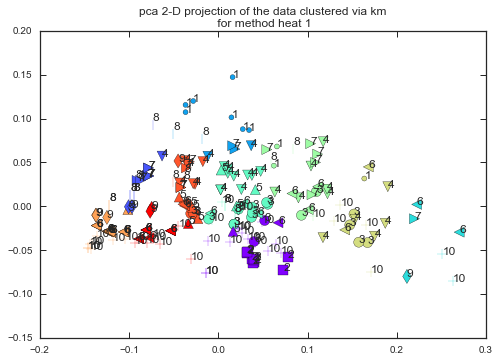

[[ 0.          0.13187407  0.18406839 ...,  0.42461077  0.16601004
   0.2126696 ]
 [ 0.13187407  0.          0.17977728 ...,  0.41641641  0.13181124
   0.1700086 ]
 [ 0.18406839  0.17977728  0.         ...,  0.31052269  0.15450218
   0.28483127]
 ..., 
 [ 0.42461077  0.41641641  0.31052269 ...,  0.          0.34933288
   0.49398565]
 [ 0.16601004  0.13181124  0.15450218 ...,  0.34933288  0.          0.16544181]
 [ 0.2126696   0.1700086   0.28483127 ...,  0.49398565  0.16544181  0.        ]]


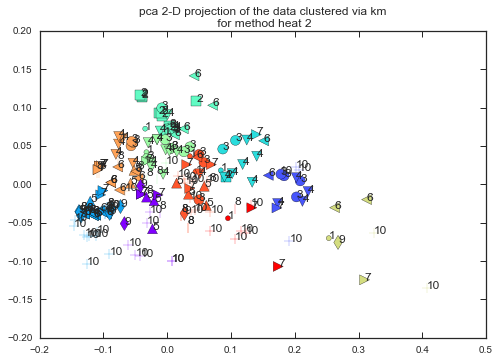

[[ 0.          0.14801925  0.21587358 ...,  0.49075551  0.20717054
   0.2205982 ]
 [ 0.14801925  0.          0.20797783 ...,  0.50262582  0.1606849
   0.1653769 ]
 [ 0.21587358  0.20797783  0.         ...,  0.37139227  0.1523617
   0.25740957]
 ..., 
 [ 0.49075551  0.50262582  0.37139227 ...,  0.          0.38815246
   0.544174  ]
 [ 0.20717054  0.1606849   0.1523617  ...,  0.38815246  0.          0.18184926]
 [ 0.2205982   0.1653769   0.25740957 ...,  0.544174    0.18184926  0.        ]]


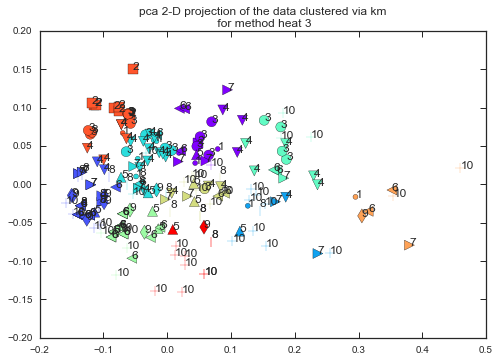

[[ 0.          0.12678544  0.23594416 ...,  0.48448247  0.20104603
   0.20356267]
 [ 0.12678544  0.          0.23240741 ...,  0.4982911   0.16365411
   0.16524711]
 [ 0.23594416  0.23240741  0.         ...,  0.38333507  0.18191196
   0.2399423 ]
 ..., 
 [ 0.48448247  0.4982911   0.38333507 ...,  0.          0.37738084
   0.51755896]
 [ 0.20104603  0.16365411  0.18191196 ...,  0.37738084  0.          0.16567482]
 [ 0.20356267  0.16524711  0.2399423  ...,  0.51755896  0.16567482  0.        ]]


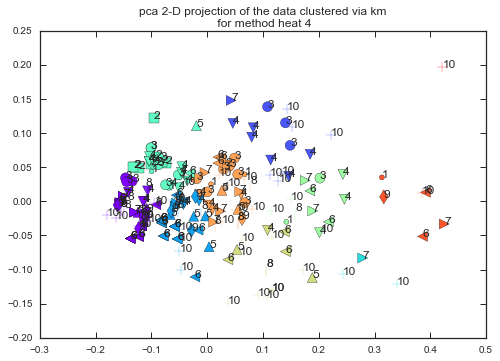

[[ 0.          0.1423784   0.25967805 ...,  0.46844249  0.15878435
   0.14678792]
 [ 0.1423784   0.          0.26921803 ...,  0.47092042  0.16193859
   0.13738465]
 [ 0.25967805  0.26921803  0.         ...,  0.40244658  0.22498536
   0.22660488]
 ..., 
 [ 0.46844249  0.47092042  0.40244658 ...,  0.          0.36401285
   0.4746762 ]
 [ 0.15878435  0.16193859  0.22498536 ...,  0.36401285  0.          0.151088  ]
 [ 0.14678792  0.13738465  0.22660488 ...,  0.4746762   0.151088    0.        ]]


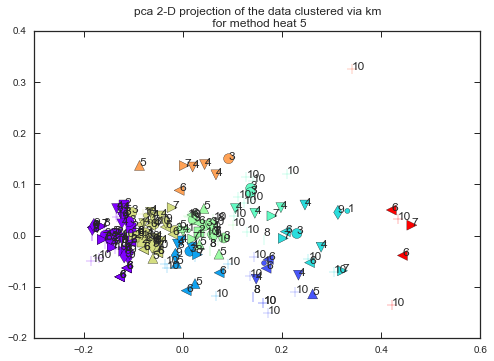

[[ 0.          0.13903606  0.27589065 ...,  0.44259939  0.16833081
   0.14587749]
 [ 0.13903606  0.          0.28306963 ...,  0.4322727   0.14068326
   0.11152408]
 [ 0.27589065  0.28306963  0.         ...,  0.40171605  0.29107984
   0.24844235]
 ..., 
 [ 0.44259939  0.4322727   0.40171605 ...,  0.          0.32251684
   0.41419619]
 [ 0.16833081  0.14068326  0.29107984 ...,  0.32251684  0.          0.14334639]
 [ 0.14587749  0.11152408  0.24844235 ...,  0.41419619  0.14334639  0.        ]]


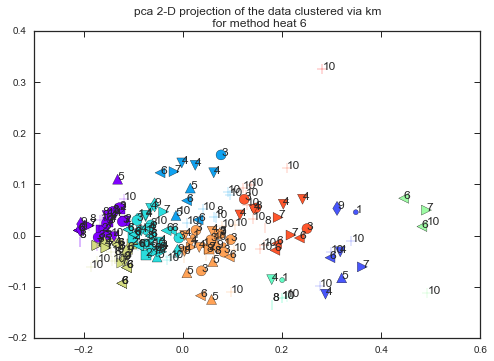

[[ 0.          0.14821556  0.29077228 ...,  0.42263904  0.19170583
   0.1787163 ]
 [ 0.14821556  0.          0.31666978 ...,  0.39569919  0.12014471
   0.11514161]
 [ 0.29077228  0.31666978  0.         ...,  0.42679403  0.34164876
   0.29903721]
 ..., 
 [ 0.42263904  0.39569919  0.42679403 ...,  0.          0.29611405
   0.37120818]
 [ 0.19170583  0.12014471  0.34164876 ...,  0.29611405  0.          0.12311603]
 [ 0.1787163   0.11514161  0.29903721 ...,  0.37120818  0.12311603  0.        ]]


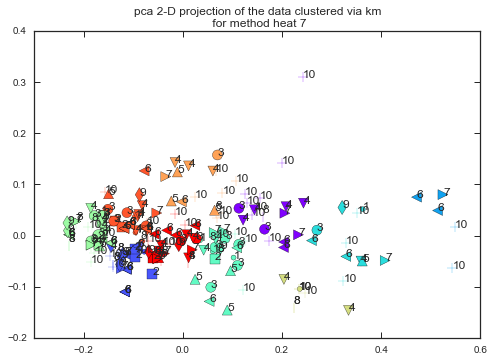

[[ 0.          0.15841786  0.29782396 ...,  0.40779851  0.20412403
   0.20031748]
 [ 0.15841786  0.          0.33315639 ...,  0.38378676  0.13636034
   0.12267219]
 [ 0.29782396  0.33315639  0.         ...,  0.4455219   0.37632662
   0.33497333]
 ..., 
 [ 0.40779851  0.38378676  0.4455219  ...,  0.          0.28664138
   0.34978608]
 [ 0.20412403  0.13636034  0.37632662 ...,  0.28664138  0.          0.14625713]
 [ 0.20031748  0.12267219  0.33497333 ...,  0.34978608  0.14625713  0.        ]]


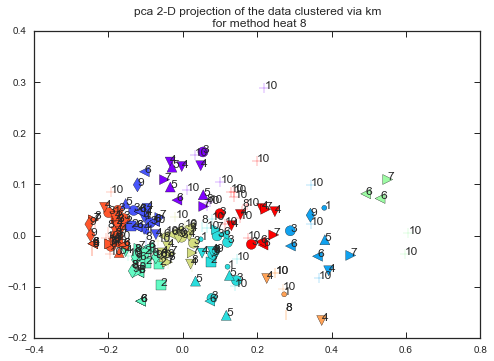

[[ 0.          0.16225688  0.29540239 ...,  0.39200832  0.22686732
   0.20967991]
 [ 0.16225688  0.          0.33565558 ...,  0.37253157  0.15584584
   0.13657399]
 [ 0.29540239  0.33565558  0.         ...,  0.44114488  0.40415715
   0.36673202]
 ..., 
 [ 0.39200832  0.37253157  0.44114488 ...,  0.          0.278198
   0.31746058]
 [ 0.22686732  0.15584584  0.40415715 ...,  0.278198    0.          0.14314069]
 [ 0.20967991  0.13657399  0.36673202 ...,  0.31746058  0.14314069  0.        ]]


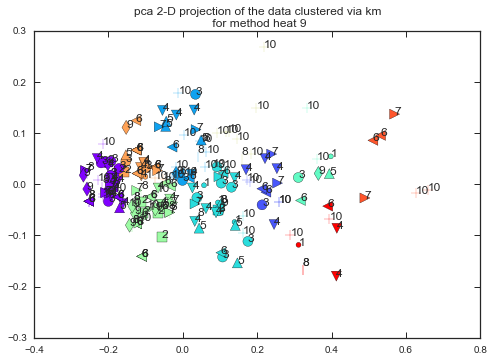

[[ 0.          0.16400276  0.29125712 ...,  0.3867408   0.2449092
   0.23654333]
 [ 0.16400276  0.          0.33775512 ...,  0.36655208  0.16204508
   0.17303774]
 [ 0.29125712  0.33775512  0.         ...,  0.44227234  0.41982803
   0.40789515]
 ..., 
 [ 0.3867408   0.36655208  0.44227234 ...,  0.          0.28110749
   0.30319614]
 [ 0.2449092   0.16204508  0.41982803 ...,  0.28110749  0.          0.13452719]
 [ 0.23654333  0.17303774  0.40789515 ...,  0.30319614  0.13452719  0.        ]]


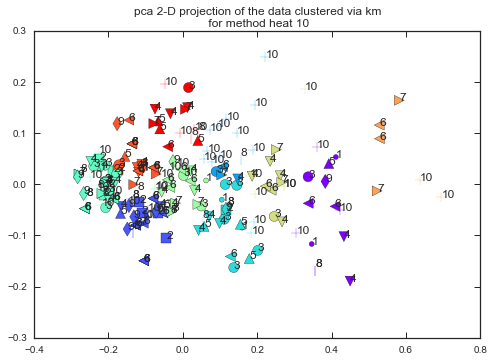

[[ 0.          0.1662364   0.28910262 ...,  0.39098627  0.25562971
   0.27440677]
 [ 0.1662364   0.          0.34368181 ...,  0.37108251  0.16486012
   0.2174171 ]
 [ 0.28910262  0.34368181  0.         ...,  0.45548292  0.43173669
   0.45187877]
 ..., 
 [ 0.39098627  0.37108251  0.45548292 ...,  0.          0.2885788
   0.31806523]
 [ 0.25562971  0.16486012  0.43173669 ...,  0.2885788   0.          0.15338889]
 [ 0.27440677  0.2174171   0.45187877 ...,  0.31806523  0.15338889  0.        ]]


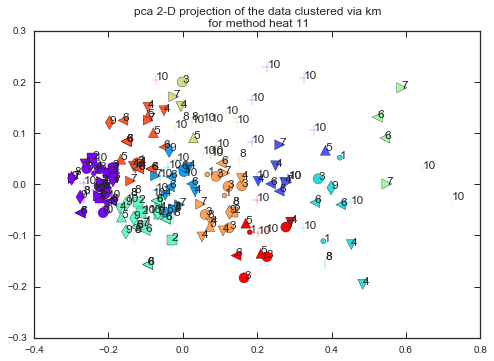

[[ 0.          0.16938575  0.28939361 ...,  0.39910052  0.26361692
   0.31000336]
 [ 0.16938575  0.          0.35278961 ...,  0.38111738  0.17091945
   0.25757575]
 [ 0.28939361  0.35278961  0.         ...,  0.47731005  0.44681086
   0.49252624]
 ..., 
 [ 0.39910052  0.38111738  0.47731005 ...,  0.          0.29216841
   0.33986361]
 [ 0.26361692  0.17091945  0.44681086 ...,  0.29216841  0.          0.18543878]
 [ 0.31000336  0.25757575  0.49252624 ...,  0.33986361  0.18543878  0.        ]]


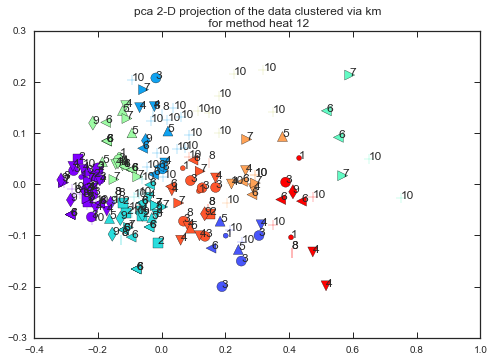

[[ 0.          0.17356473  0.29144109 ...,  0.40726959  0.27229827
   0.33958757]
 [ 0.17356473  0.          0.36369214 ...,  0.39079468  0.18094854
   0.29108483]
 [ 0.29144109  0.36369214  0.         ...,  0.50255234  0.4664049
   0.52853929]
 ..., 
 [ 0.40726959  0.39079468  0.50255234 ...,  0.          0.28881398
   0.35108903]
 [ 0.27229827  0.18094854  0.4664049  ...,  0.28881398  0.          0.21288462]
 [ 0.33958757  0.29108483  0.52853929 ...,  0.35108903  0.21288462  0.        ]]


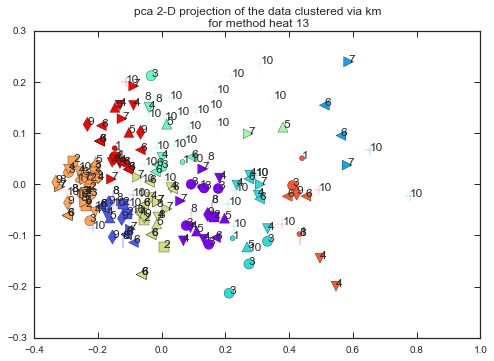

[[ 0.          0.1792027   0.29426735 ...,  0.41465105  0.28323088
   0.36470507]
 [ 0.1792027   0.          0.37550888 ...,  0.39921072  0.19394206
   0.31910689]
 [ 0.29426735  0.37550888  0.         ...,  0.52777112  0.48935602
   0.56085324]
 ..., 
 [ 0.41465105  0.39921072  0.52777112 ...,  0.          0.2805032
   0.35099717]
 [ 0.28323088  0.19394206  0.48935602 ...,  0.2805032   0.          0.23127119]
 [ 0.36470507  0.31910689  0.56085324 ...,  0.35099717  0.23127119  0.        ]]


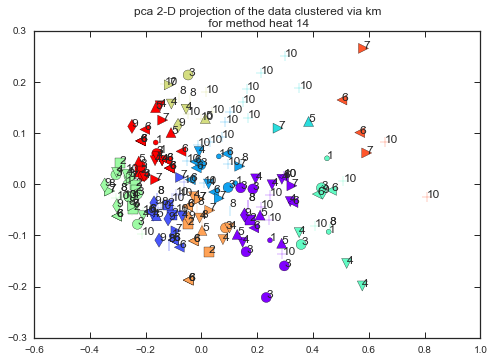

[[ 0.          0.18678258  0.29698315 ...,  0.42163944  0.29703475
   0.38792657]
 [ 0.18678258  0.          0.38790245 ...,  0.40762343  0.20897911
   0.34317011]
 [ 0.29698315  0.38790245  0.         ...,  0.55126565  0.51422732
   0.59073505]
 ..., 
 [ 0.42163944  0.40762343  0.55126565 ...,  0.          0.27074484
   0.34585114]
 [ 0.29703475  0.20897911  0.51422732 ...,  0.27074484  0.          0.24175688]
 [ 0.38792657  0.34317011  0.59073505 ...,  0.34585114  0.24175688  0.        ]]


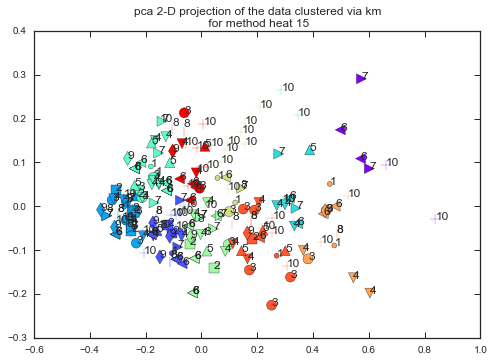

[[ 0.          0.19644724  0.29901598 ...,  0.42873942  0.31388767
   0.41115241]
 [ 0.19644724  0.          0.40083587 ...,  0.41678208  0.22533486
   0.36432976]
 [ 0.29901598  0.40083587  0.         ...,  0.57241995  0.53999625
   0.61915571]
 ..., 
 [ 0.42873942  0.41678208  0.57241995 ...,  0.          0.26216478
   0.34127435]
 [ 0.31388767  0.22533486  0.53999625 ...,  0.26216478  0.          0.24656242]
 [ 0.41115241  0.36432976  0.61915571 ...,  0.34127435  0.24656242  0.        ]]


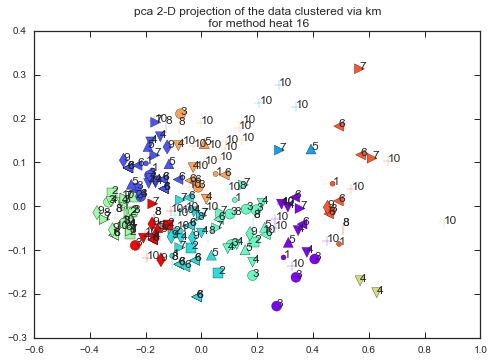

[[ 0.          0.20786     0.30021094 ...,  0.43635267  0.33359769
   0.43524151]
 [ 0.20786     0.          0.4143542  ...,  0.42657414  0.24237632
   0.38319979]
 [ 0.30021094  0.4143542   0.         ...,  0.59132691  0.56606924
   0.64673828]
 ..., 
 [ 0.43635267  0.42657414  0.59132691 ...,  0.          0.25594498
   0.33988841]
 [ 0.33359769  0.24237632  0.56606924 ...,  0.25594498  0.          0.24757999]
 [ 0.43524151  0.38319979  0.64673828 ...,  0.33988841  0.24757999  0.        ]]


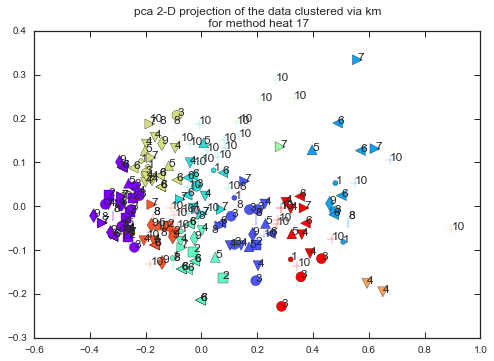

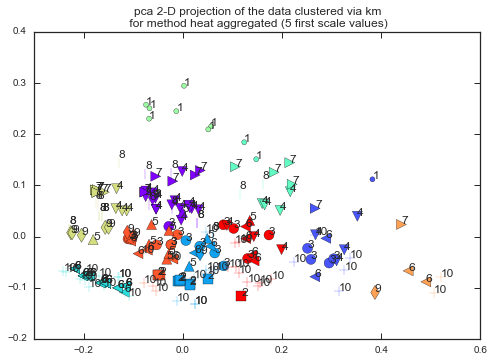

smax= 18  and smin= 5


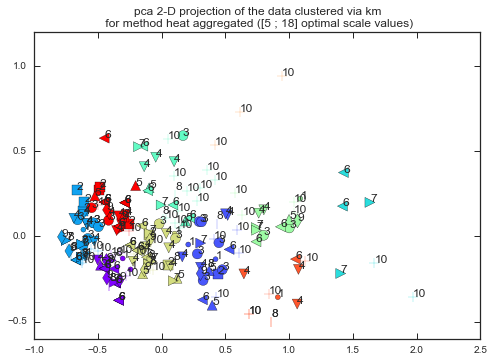

smax= 19  and smin= 4


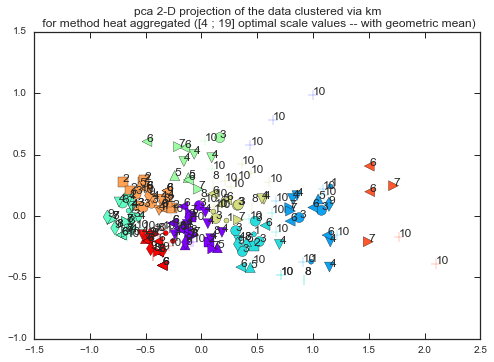

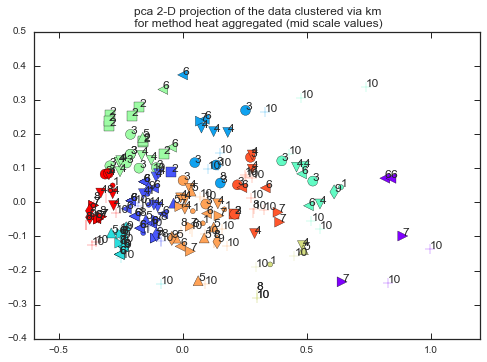

start= 0
start= 7
start= 14
start= 21
start= 28
start= 35
start= 42
start= 49
start= 56
start= 63
start= 70
start= 75
start= 80
start= 85
start= 90
start= 95
start= 100
start= 105
start= 110
start= 115
start= 120
start= 125
start= 130
start= 135
start= 140
start= 145
start= 150
start= 155
start= 160
start= 165
(0, 24)
[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 4

2017-10-04 20:18:25,276:[INFO](pygsp.filters.filter.__init__): Heat : has to compute lmax
2017-10-04 20:18:25,293:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 20:18:25,331:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 20:18:25,379:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 20:18:25,420:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 20:18:25,510:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 20:18:25,622:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 20:18:25,671:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 20:18:25,699:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 20:18:25,735:[INFO](pygsp.filters.filter.analysis): The analysis method is cheby
2017-10-04 20:18:25,767:[INFO](pygsp.filters.filter.analysis): The analysis method

Creating Vertex Features matrix
V is a 210 by 181 matrix.
Node-role matrix is of dimensions 210 by 10
[[ 1034.             0.0592068     12.         ...,     0.0093233
      0.0093233     12.        ]
 [    0.             0.05913978     4.         ...,     0.00334763
      0.00334763     4.        ]
 [ 2437.             0.06276276     8.         ...,     0.00617668
      0.00617668     8.        ]
 ..., 
 [    0.             0.0805395      2.         ...,     0.00241835
      0.00241835     2.        ]
 [    0.             0.05653232     2.         ...,     0.00280796
      0.00280796     2.        ]
 [ 7388.             0.05810398     6.         ...,     0.00450031
      0.00450031     6.        ]]
[[ 0.          0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.05460472  0.10272897  0.07412507  0.07414939  0.07980742
   0.0798079   0.10275806]
 [ 0.          0.          0.02307787  0.          0.          0.          0.
   0.02302952]
 [ 0

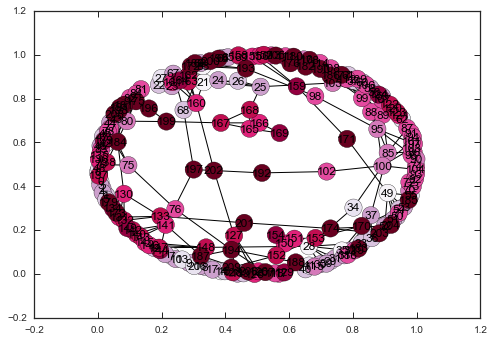

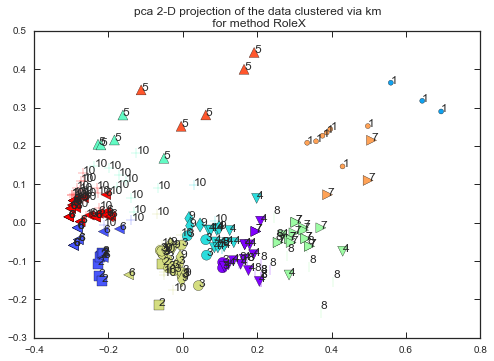

In [ ]:
Perf_tot=0.05*Perf
D_classes_tot={k:0.05*D_classes[k] for k in D_classes.keys()}
print "starting summary"
for i in range(19):
    G,colors, index_roles, label_shape=build_lego_structure_from_structure(list_shapes, start=0,plot=True,savefig=False,graph_type='nx.connected_watts_strogatz_graph', graph_args=[3,0.4],save2text='/Users/cdonnat/Desktop/structural_equivalents/graphs/',add_node=40)
    taus=range(1,20,1)
    heat_print=heat_diffusion(G,taus,diff_type="immediate",type_graph="nx")
    D, chi, Perf,D_classes_temp=clustering_comparative_analysis(G, index_roles, heat_print,nb_clust,dirpath='../../structural_equivalents',graph_nodes_name=name_graph+'_nodes.txt',graph_edges_name=name_graph+'_edges.txt',agg_max=5,struc2vec_input=name_graph+'_edges.txt',struc2vec_output=name_graph+'_struc2vec.txt')
    Perf_tot+=0.05*Perf
    D_classes_tot={k:0.05*D_classes_temp[k]+D_classes_tot[k] for k in D_classes.keys()}

In [ ]:
len(np.unique(colors))


In [ ]:
i


In [ ]:
## Visualize the Characteristic signatures associated to a "bunch" of nodes
bunch=[0,1,2,3,5,16,21,24,25,29]
cmap=plt.get_cmap('inferno')
x=np.linspace(0,1,N)
mode=2
plot_bunch_characteristic_functions(heat_print,mode, bunch,color_bunch=[colors[b] for b in bunch],savefig=False,fileplot="plots_paper/plot_characteristic_perturbed_graph.png")
 
    
    

In [ ]:
[colors[b] for b in bunch]

In [ ]:
rows=np.setdiff1d(Perf.index,['RoleX','struc2vec'])
col=['purity'+str(i) for i in range(1,16)]
score_diff=pd.DataFrame(np.zeros((Perf.shape[0]-2,15)), index=rows,columns=['purity'+str(i) for i in range(1,16)])
score_diff2=pd.DataFrame(np.zeros((Perf.shape[0]-2,15)), index=rows,columns=['purity'+str(i) for i in range(1,16)])

for r in rows:
    score_diff.loc[r]=Perf.loc[r][col]-Perf.loc['RoleX'][col]
    score_diff2.loc[r]=Perf.loc[r][col]-Perf.loc['struc2vec'][col]


    

In [ ]:
cc=0


fig, ax = plt.subplots()
sb.set(style='ticks')
sb.set_context("paper", font_scale=1.5)
ax.set_ylim([-1,5])
ax.plot(range(1,16),score_diff.iloc[1,:],c=colors_ref[cc],label="tau=1,RolX")
cc+=1
ax.plot(range(1,16),score_diff.iloc[3,:],c=colors_ref[cc],label="tau=5,RolX")
cc+=1
plt.plot(range(1,16),score_diff.iloc[7,:],c=colors_ref[cc],label="tau=15,RolX")
cc+=1
ax.plot(range(1,16),score_diff2.iloc[1,:],c=colors_ref[cc],label="tau=1, struc2Vec")
cc+=1
ax.plot(range(1,16),score_diff2.iloc[3,:],c=colors_ref[cc],label="tau=5, struc2Vec")
cc+=1
plt.plot(range(1,16),score_diff2.iloc[7,:],c=colors_ref[cc],label="tau=15, struc2Vec")
cc+=1
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.legend(loc="upper left")
plt.title("Difference in Neighbor Purity levels for different scales")


In [ ]:
Perf.loc[rows[0]]

In [ ]:
score_diff.iloc[1,:]

In [ ]:
##### Visualize the nearest neighbor graph obtained for each scale/mode value

compute_nearest_role=True
if compute_nearest_role==True:
    A={}
    for tau in D.keys():
            G_role=nx.Graph()
            G_role.add_nodes_from(range(nx.number_of_nodes(G)))
            k=3 ### Numbers of neighbors needed for our perturbation test
            score=0
            for n in range(nx.number_of_nodes(G)):
                neighbors=np.argsort(D[tau][n,:]).tolist()
                neighbors=neighbors[1:(k+1)]
                roles_neighbors=[colors[nn] for nn in neighbors  ]
                success_rate=len([nn for nn in neighbors if colors[nn]==colors[n] ])*1.0/k
                score+=success_rate/N
                
                for nn in neighbors:
                    G_role.add_edge(n,nn)
            plt.figure()
            nx.draw_networkx(G_role,node_color=colors,cmap="hot")    
            plt.title(tau)
            A[tau]=nx.adjacency_matrix(G_role)
            

In [ ]:
D

In [ ]:
D.keys()

In [ ]:
AA=nx.adjacency_matrix(G)
N=G.number_of_nodes()
Gg = pygsp.graphs.Graph(AA)

In [ ]:
Gg.compute_fourier_basis()

In [ ]:
0.1*Gg.e[-1]/Gg.e[1]

In [ ]:
(0.1*6)**(1.0/3)/Gg.e[1]